In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import random, copy
from collections import deque
from datetime import datetime
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [2]:
SEED_VALUE = 42
BUFFER_CAPACITY = 1000000
T_LR = 0.001
BUFFER_FILL_MATCH_COUNT = 256
BEST_MATCHES_COUNT = 8
VARIATION_RANGE = 2
GAMMA = 0.995
BATCH_SIZE = 128
RACE_COUNT = 10
NUM_MODEL = 10
NUM_EPOCH = 10
FINAL_RACE_COUNT = 500
RACE_PERCENT = 20
BEST_N = 2

In [3]:
plot_path = "plots/Trainee_Multiplier_Model_42_CartPole/"

In [4]:
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [5]:
# helper functions
def random_mul(val):
    '''
    gerates random number around 1
    val: deviation from 1
    '''
    return random.uniform(1 - val, 1 + val)

def max_two_index(l):
    m = sorted(l)
    n = m[-1]
    max_index_1 = [x for x in range(len(l)) if l[x] == n]
    o = [x for x in m if x != n]
    if len(o) == 0:
        return sorted(max_index_1)
    else:
        p = o[-1]
        max_index_2 = [x for x in range(len(l)) if l[x] == p]
        return sorted(max_index_1 + max_index_2)

def max_val_index(l):
    m = sorted(l)
    n = m[-1]
    max_index = [x for x in range(len(l)) if l[x] == n]
    return n, max_index[0]

def max_indices(l, length):
    m = list(set(l))
    n = sorted(m, reverse=True)
    o = min(length, len(n))
    p = n[:o]
    q = []
    for i in range(len(l)):
        for el in p:
            if el == l[i]:
                q.append(i)
    return sorted(list(set(q)))

def good_val_indices(l, percent, rank):
    m = max(l)
    n = min(l)
    o = m - (m - n) * (percent / 100)
    p1 = [i for i in range(len(l)) if l[i] == m]
    if len(p1) >= rank:
        return sorted(p1[:rank])
    q1 = [el for el in l if el != m]
    m1 = max(q1)
    p2 = [i for i in range(len(l)) if l[i] == m1][0]
    p = [i for i in range(len(l)) if o <= l[i] <= m]
    q = list(set(p).intersection(set([p2, p1[0]])))
    return sorted(q)

def biased_mean(l):
    if len(l) < 100:
        return 0
    else:
        return sum(l) / len(l)

def quad(x, r):
    return - 10 * ((x*x/(r+1))-x+1)

In [6]:
class Trainee:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.model = self.nn_model()
        self.opt = tf.keras.optimizers.Adam(T_LR)

    def nn_model(self):
        inputs = Input((self.state_dim,))
        d1 = Dense(32, activation="relu")(inputs)
        d2 = Dense(32, activation="relu")(d1)
        outputs = Dense(1, activation="sigmoid")(d2)
        return tf.keras.Model(inputs, outputs)

    def get_action(self, state):
        state = np.array(state)
        predicted = self.model.predict(state)
        return 1 if predicted > 0.5 else 0

    def train(self, states, r_grads):
        r_grads = tf.convert_to_tensor(r_grads, dtype=tf.float32)
        with tf.GradientTape() as tape:
            x = self.model(states, training=True)
            grads = tape.gradient(x, self.model.trainable_variables, r_grads)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

In [7]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, info):
        self.buffer.append(info)

    def sample(self):
        sample = random.sample(self.buffer, BATCH_SIZE)
        states, r_grads = map(np.asarray, zip(*sample))
        states = np.array(states).reshape(BATCH_SIZE, -1)
        r_grads = np.array(r_grads).reshape(BATCH_SIZE, -1)
        return states, r_grads

    def size(self):
        return len(self.buffer)

In [8]:
class Agent:
    def __init__(self, env_name):
        self.env = gym.make(env_name)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.trs = [Trainee(self.state_dim) for _ in range(NUM_MODEL)]
        self.buffer = ReplayBuffer(BUFFER_CAPACITY)
        self.best_model = self.trs[0]

    def runners(self, model_list, weights, indices):
        delisted_indices = [i for i in range(NUM_MODEL) if i not in indices]
        for i in delisted_indices:
            updated_weights = [x * random_mul(VARIATION_RANGE) for x in weights]
            model_list[i].model.set_weights(updated_weights)
        return model_list

    def buffer_filler(self, best_model, index):
        temp_buffer_list = []
        ep_return_list = []
        for _ in range(BUFFER_FILL_MATCH_COUNT):
            ep_return = 0
            temp_buffer = []
            return_t = 0
            done = False
            state = self.env.reset()
            while not done:
                action = best_model.get_action([state])
                next_state, reward, done, _ = self.env.step(action)
                state = next_state
                ep_return += reward
                # r_grad = - (reward + (1 - GAMMA) * return_t) / (return_t + 0.1)
                x = reward + (1 - GAMMA) * return_t
                r_grad = quad(x, return_t)
                return_t = reward + GAMMA * return_t
                temp_buffer.append([state, r_grad])
            ep_return_list.append(ep_return)
            temp_buffer_list.append(temp_buffer)
        imp_index = max_indices(ep_return_list, BEST_MATCHES_COUNT)
        num_stored = 0
        for i in imp_index:
            for x in temp_buffer_list[i]:
                num_stored += 1
                self.buffer.store(x)
        for_plot = [ep_return_list[i] for i in imp_index]
        plt.plot(for_plot)
        plt.title(f"Buffer input Returns of race {index} with injection {num_stored}")
        plt.savefig(plot_path + f"buffer_returns_{index}.png")
        plt.show()
        
    def train_from_buffer(self, model_list):
        for m in model_list:
            for _ in range(NUM_EPOCH):
                states, r_grads = self.buffer.sample()
                m.train(states, r_grads)
    
    def race(self, model_list, index):
        race_avg = [0] * NUM_MODEL
        for i in range(NUM_MODEL):
            reward_sum = 0
            for _ in range(RACE_COUNT):
                done = False
                state = self.env.reset()
                while not done:
                    action = model_list[i].get_action([state])
                    next_state, reward, done, _ = self.env.step(action)
                    state = next_state
                    reward_sum += reward
            race_avg[i] = reward_sum / RACE_COUNT
        plt.plot(race_avg)
        plt.title(f"Racer Returns of race {index}")
        plt.savefig(plot_path + f"race_avg_returns_{index}.png")
        plt.show()
        return race_avg

    def train(self):
        i = 0
        for_plot = []
        ma = []
        model_list = self.trs
        while i < FINAL_RACE_COUNT and biased_mean(ma) < 200:
            print(f"Starting filling buffer: {i}...")
            self.buffer_filler(self.best_model, i)
            print("Training starts...")
            self.train_from_buffer(model_list)
            print(f"Buufer size: {self.buffer.size()}, Starting race {i}")
            race_avg = self.race(model_list, i)
            print("Race complete!")
            max_ep_reward, best_model_index = max_val_index(race_avg)
            good_model_indices = good_val_indices(race_avg, RACE_PERCENT, BEST_N)
            self.best_model = self.trs[best_model_index]
            for_plot.append(max_ep_reward)
            ma = for_plot[-(len(for_plot) if len(for_plot) < 100 else 100):]
            print(f"At race {i}, finalist model is Model#({best_model_index}) with episode reward {max_ep_reward}")
            print(f"carrying following Model numbers: {good_model_indices}")
            new_weights = model_list[best_model_index].model.get_weights()
            model_list = self.runners(model_list, new_weights, good_model_indices)
            i += 1
        plt.plot(for_plot)
        plt.title("Final Return Plot")
        plt.savefig(plot_path + "Final_Returns.png")
        plt.show()
        
    def get_final_weights(self):
        return self.best_model.model.get_weights()

Starts at 21-12-13, 11:41:42
Starting filling buffer: 0...


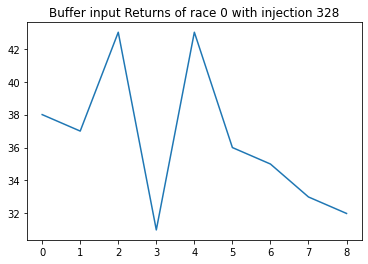

Training starts...
Buufer size: 328, Starting race 0


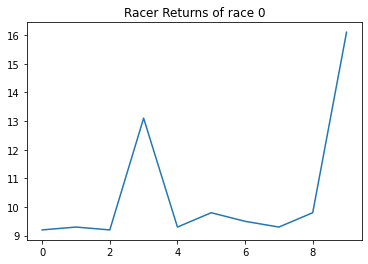

Race complete!
At race 0, finalist model is Model#(9) with episode reward 16.1
carrying following Model numbers: [9]
Starting filling buffer: 1...


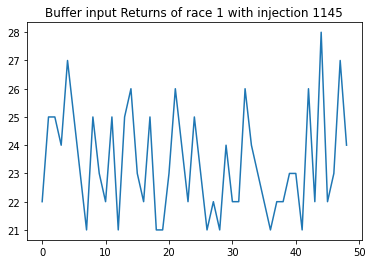

Training starts...
Buufer size: 1473, Starting race 1


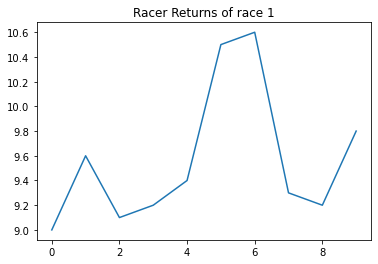

Race complete!
At race 1, finalist model is Model#(6) with episode reward 10.6
carrying following Model numbers: [5, 6]
Starting filling buffer: 2...


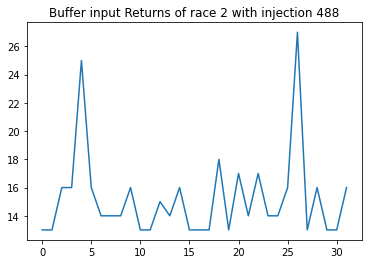

Training starts...
Buufer size: 1961, Starting race 2


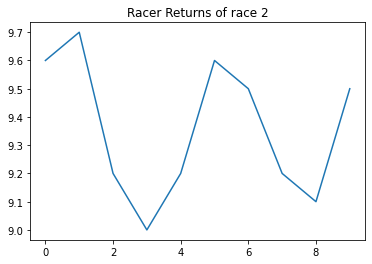

Race complete!
At race 2, finalist model is Model#(1) with episode reward 9.7
carrying following Model numbers: [0, 1]
Starting filling buffer: 3...


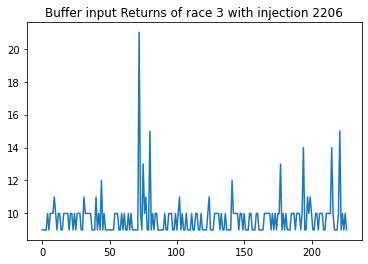

Training starts...
Buufer size: 4167, Starting race 3


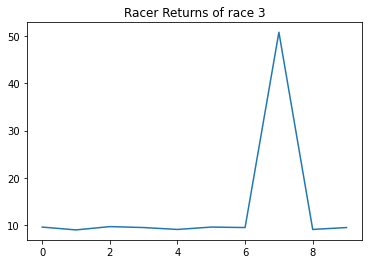

Race complete!
At race 3, finalist model is Model#(7) with episode reward 50.8
carrying following Model numbers: [7]
Starting filling buffer: 4...


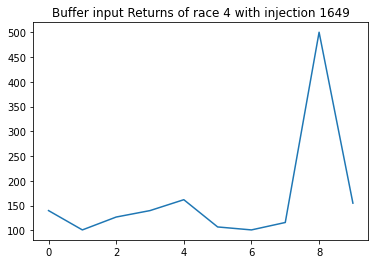

Training starts...
Buufer size: 5816, Starting race 4


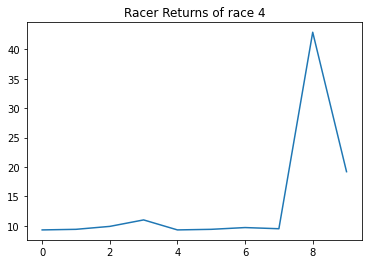

Race complete!
At race 4, finalist model is Model#(8) with episode reward 42.9
carrying following Model numbers: [8]
Starting filling buffer: 5...


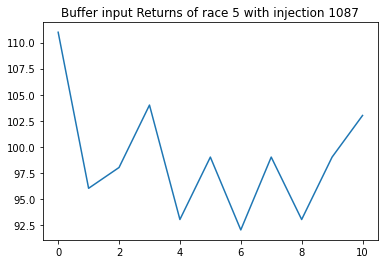

Training starts...
Buufer size: 6903, Starting race 5


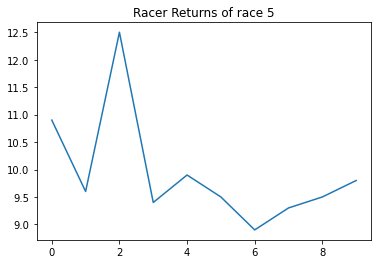

Race complete!
At race 5, finalist model is Model#(2) with episode reward 12.5
carrying following Model numbers: [2]
Starting filling buffer: 6...


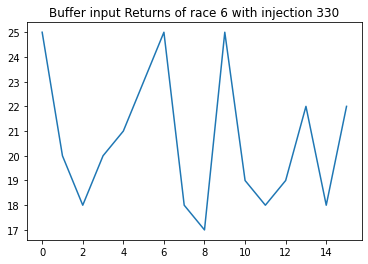

Training starts...
Buufer size: 7233, Starting race 6


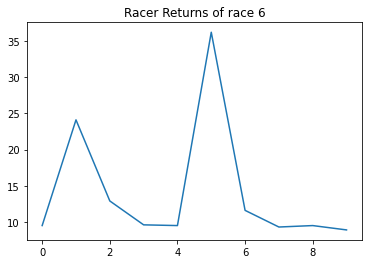

Race complete!
At race 6, finalist model is Model#(5) with episode reward 36.2
carrying following Model numbers: [5]
Starting filling buffer: 7...


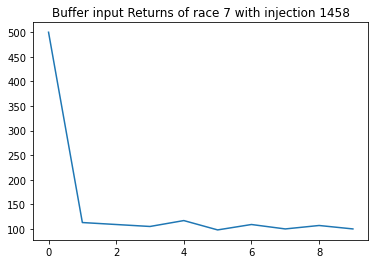

Training starts...
Buufer size: 8691, Starting race 7


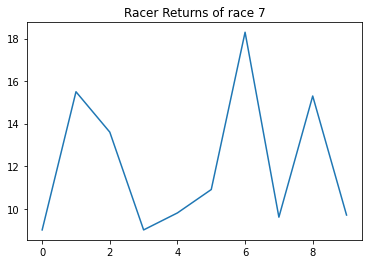

Race complete!
At race 7, finalist model is Model#(6) with episode reward 18.3
carrying following Model numbers: [6]
Starting filling buffer: 8...


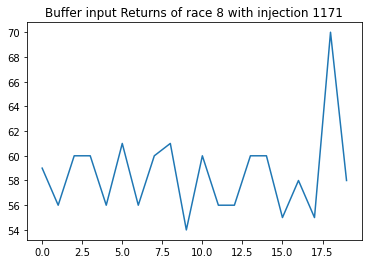

Training starts...
Buufer size: 9862, Starting race 8


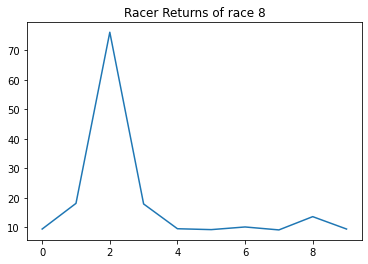

Race complete!
At race 8, finalist model is Model#(2) with episode reward 76.1
carrying following Model numbers: [2]
Starting filling buffer: 9...


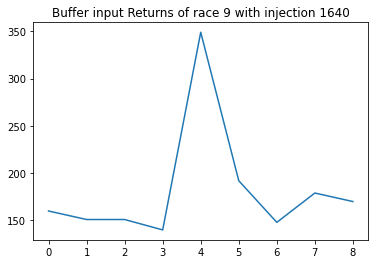

Training starts...
Buufer size: 11502, Starting race 9


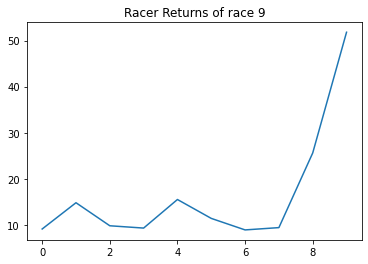

Race complete!
At race 9, finalist model is Model#(9) with episode reward 51.8
carrying following Model numbers: [9]
Starting filling buffer: 10...


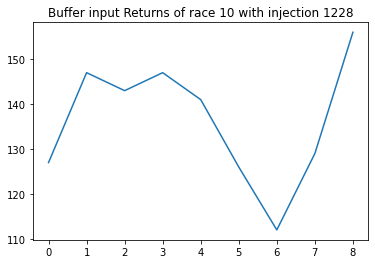

Training starts...
Buufer size: 12730, Starting race 10


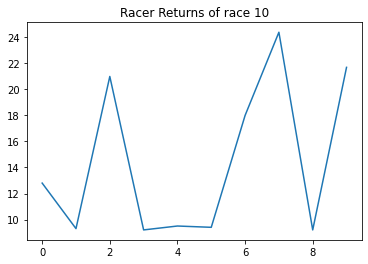

Race complete!
At race 10, finalist model is Model#(7) with episode reward 24.4
carrying following Model numbers: [7, 9]
Starting filling buffer: 11...


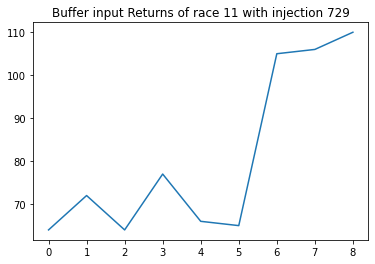

Training starts...
Buufer size: 13459, Starting race 11


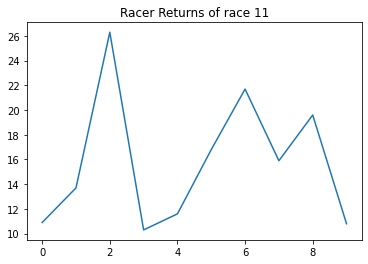

Race complete!
At race 11, finalist model is Model#(2) with episode reward 26.3
carrying following Model numbers: [2]
Starting filling buffer: 12...


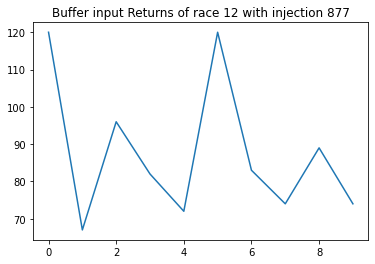

Training starts...
Buufer size: 14336, Starting race 12


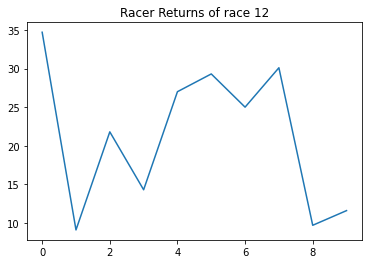

Race complete!
At race 12, finalist model is Model#(0) with episode reward 34.7
carrying following Model numbers: [0, 7]
Starting filling buffer: 13...


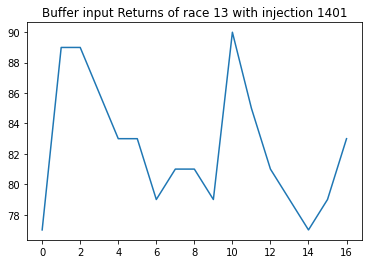

Training starts...
Buufer size: 15737, Starting race 13


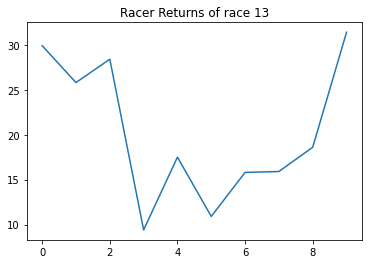

Race complete!
At race 13, finalist model is Model#(9) with episode reward 31.4
carrying following Model numbers: [0, 9]
Starting filling buffer: 14...


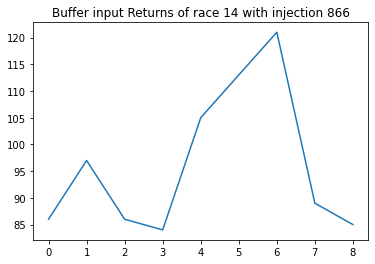

Training starts...
Buufer size: 16603, Starting race 14


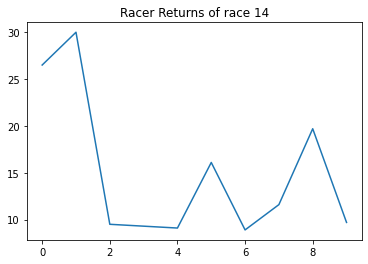

Race complete!
At race 14, finalist model is Model#(1) with episode reward 30.0
carrying following Model numbers: [0, 1]
Starting filling buffer: 15...


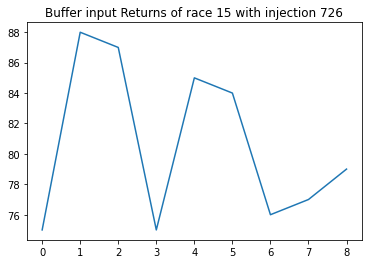

Training starts...
Buufer size: 17329, Starting race 15


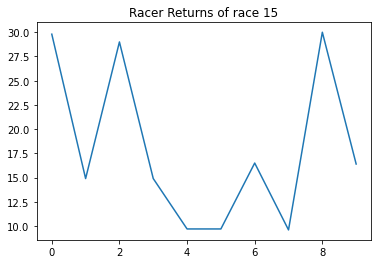

Race complete!
At race 15, finalist model is Model#(8) with episode reward 30.0
carrying following Model numbers: [0, 8]
Starting filling buffer: 16...


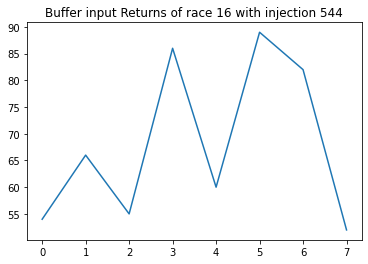

Training starts...
Buufer size: 17873, Starting race 16


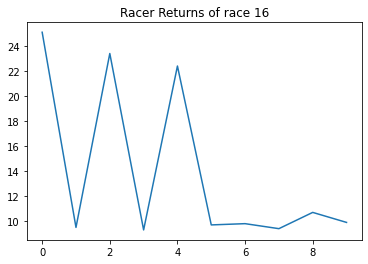

Race complete!
At race 16, finalist model is Model#(0) with episode reward 25.1
carrying following Model numbers: [0, 2]
Starting filling buffer: 17...


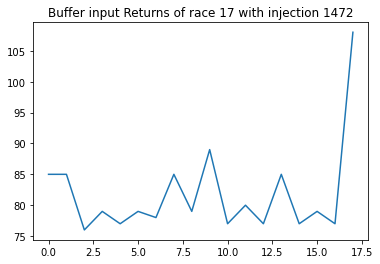

Training starts...
Buufer size: 19345, Starting race 17


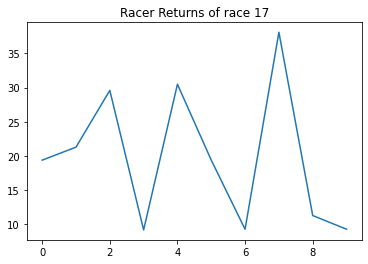

Race complete!
At race 17, finalist model is Model#(7) with episode reward 38.1
carrying following Model numbers: [7]
Starting filling buffer: 18...


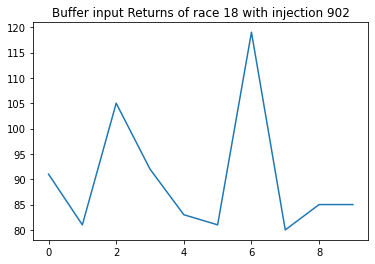

Training starts...
Buufer size: 20247, Starting race 18


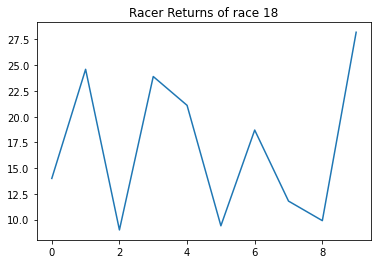

Race complete!
At race 18, finalist model is Model#(9) with episode reward 28.2
carrying following Model numbers: [1, 9]
Starting filling buffer: 19...


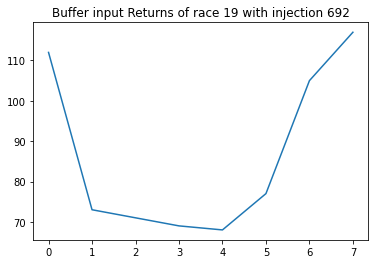

Training starts...
Buufer size: 20939, Starting race 19


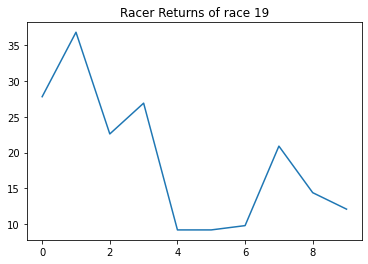

Race complete!
At race 19, finalist model is Model#(1) with episode reward 36.8
carrying following Model numbers: [1]
Starting filling buffer: 20...


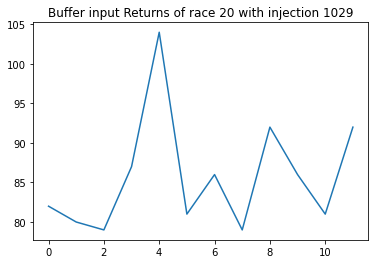

Training starts...
Buufer size: 21968, Starting race 20


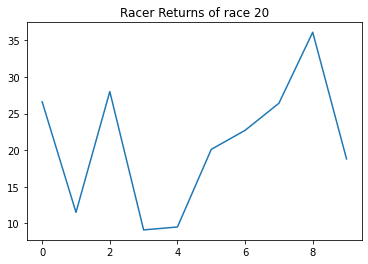

Race complete!
At race 20, finalist model is Model#(8) with episode reward 36.1
carrying following Model numbers: [8]
Starting filling buffer: 21...


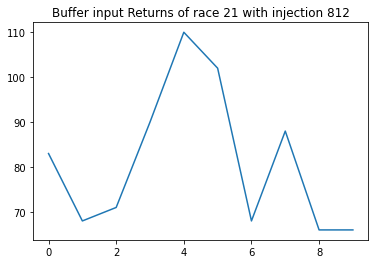

Training starts...
Buufer size: 22780, Starting race 21


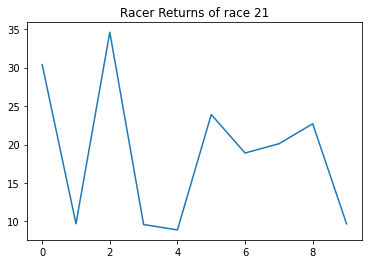

Race complete!
At race 21, finalist model is Model#(2) with episode reward 34.6
carrying following Model numbers: [0, 2]
Starting filling buffer: 22...


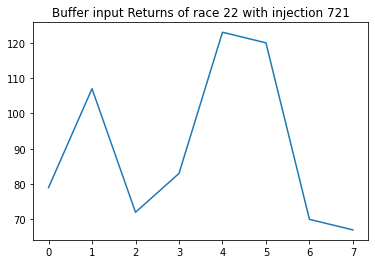

Training starts...
Buufer size: 23501, Starting race 22


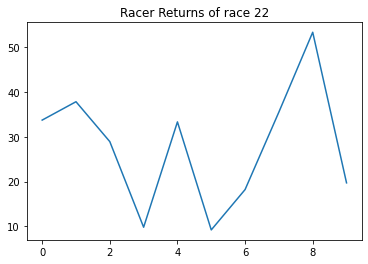

Race complete!
At race 22, finalist model is Model#(8) with episode reward 53.3
carrying following Model numbers: [8]
Starting filling buffer: 23...


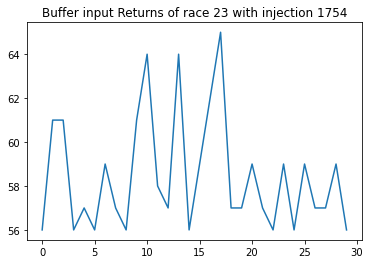

Training starts...
Buufer size: 25255, Starting race 23


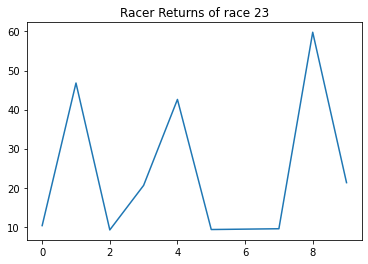

Race complete!
At race 23, finalist model is Model#(8) with episode reward 59.8
carrying following Model numbers: [8]
Starting filling buffer: 24...


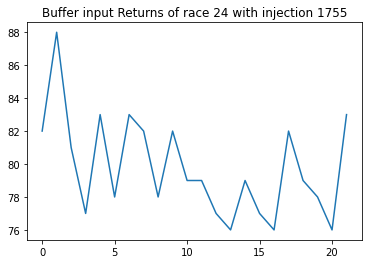

Training starts...
Buufer size: 27010, Starting race 24


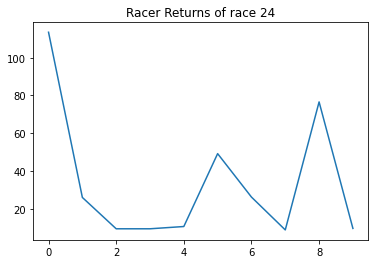

Race complete!
At race 24, finalist model is Model#(0) with episode reward 113.5
carrying following Model numbers: [0]
Starting filling buffer: 25...


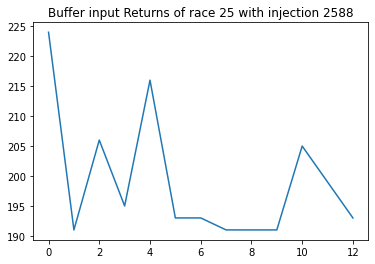

Training starts...
Buufer size: 29598, Starting race 25


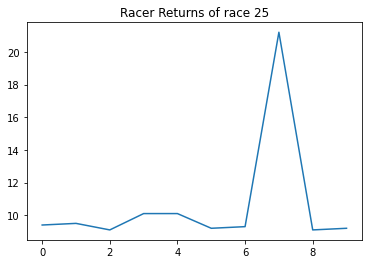

Race complete!
At race 25, finalist model is Model#(7) with episode reward 21.2
carrying following Model numbers: [7]
Starting filling buffer: 26...


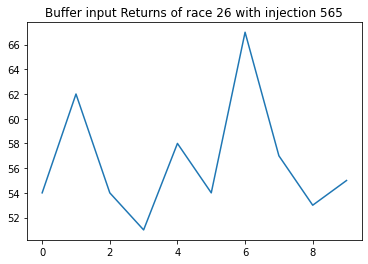

Training starts...
Buufer size: 30163, Starting race 26


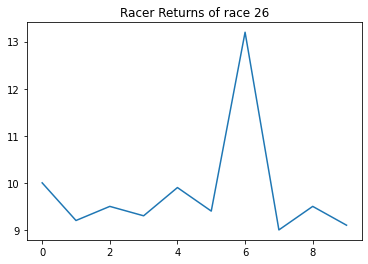

Race complete!
At race 26, finalist model is Model#(6) with episode reward 13.2
carrying following Model numbers: [6]
Starting filling buffer: 27...


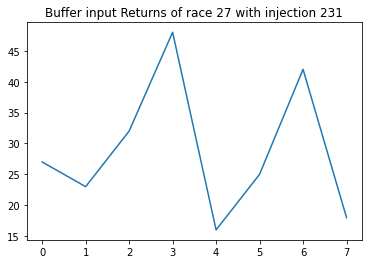

Training starts...
Buufer size: 30394, Starting race 27


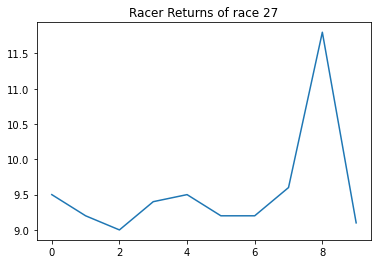

Race complete!
At race 27, finalist model is Model#(8) with episode reward 11.8
carrying following Model numbers: [8]
Starting filling buffer: 28...


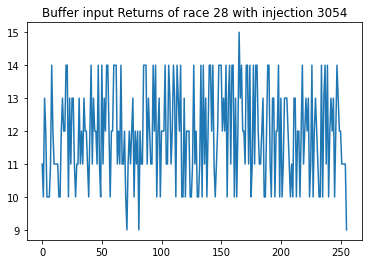

Training starts...
Buufer size: 33448, Starting race 28


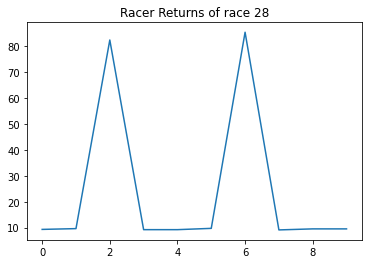

Race complete!
At race 28, finalist model is Model#(6) with episode reward 85.5
carrying following Model numbers: [2, 6]
Starting filling buffer: 29...


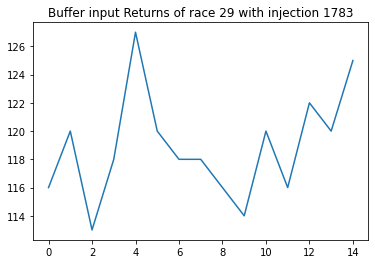

Training starts...
Buufer size: 35231, Starting race 29


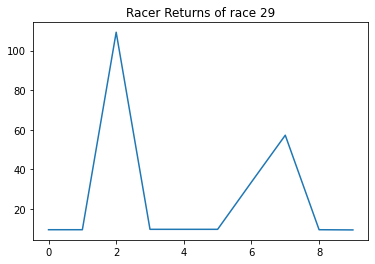

Race complete!
At race 29, finalist model is Model#(2) with episode reward 109.3
carrying following Model numbers: [2]
Starting filling buffer: 30...


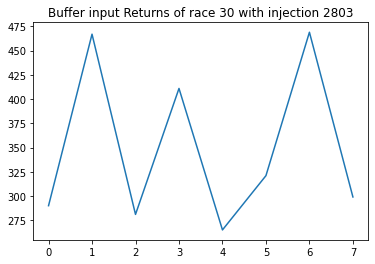

Training starts...
Buufer size: 38034, Starting race 30


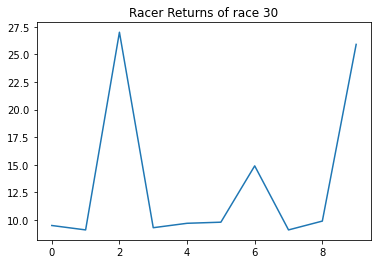

Race complete!
At race 30, finalist model is Model#(2) with episode reward 27.0
carrying following Model numbers: [2, 9]
Starting filling buffer: 31...


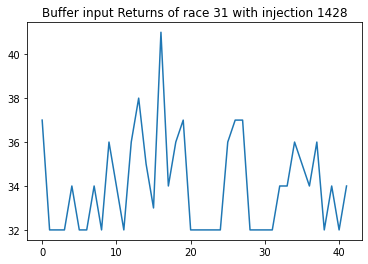

Training starts...
Buufer size: 39462, Starting race 31


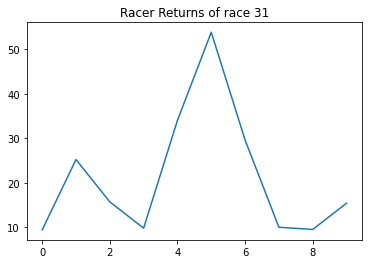

Race complete!
At race 31, finalist model is Model#(5) with episode reward 53.8
carrying following Model numbers: [5]
Starting filling buffer: 32...


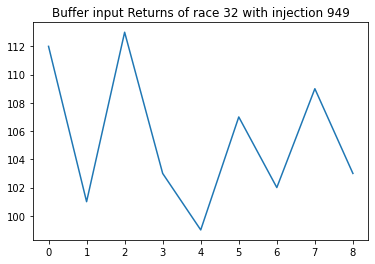

Training starts...
Buufer size: 40411, Starting race 32


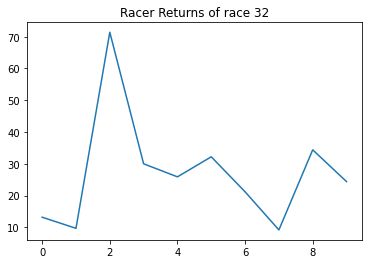

Race complete!
At race 32, finalist model is Model#(2) with episode reward 71.4
carrying following Model numbers: [2]
Starting filling buffer: 33...


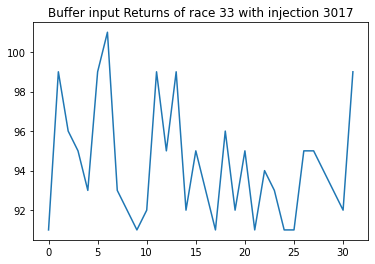

Training starts...
Buufer size: 43428, Starting race 33


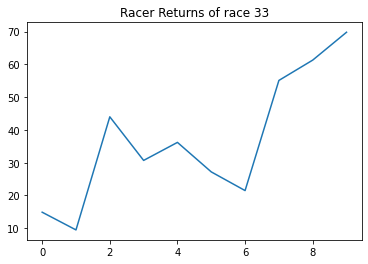

Race complete!
At race 33, finalist model is Model#(9) with episode reward 69.8
carrying following Model numbers: [8, 9]
Starting filling buffer: 34...


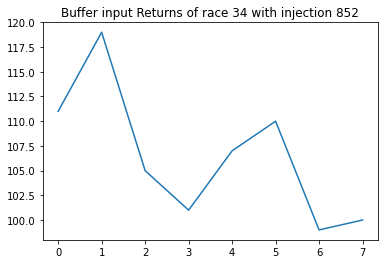

Training starts...
Buufer size: 44280, Starting race 34


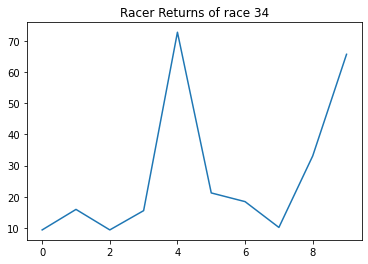

Race complete!
At race 34, finalist model is Model#(4) with episode reward 72.9
carrying following Model numbers: [4, 9]
Starting filling buffer: 35...


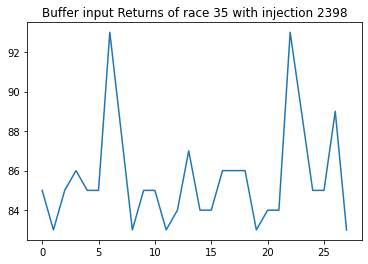

Training starts...
Buufer size: 46678, Starting race 35


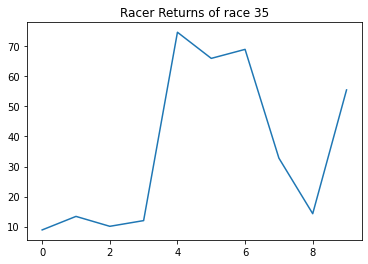

Race complete!
At race 35, finalist model is Model#(4) with episode reward 74.7
carrying following Model numbers: [4, 6]
Starting filling buffer: 36...


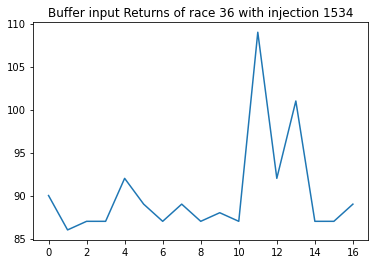

Training starts...
Buufer size: 48212, Starting race 36


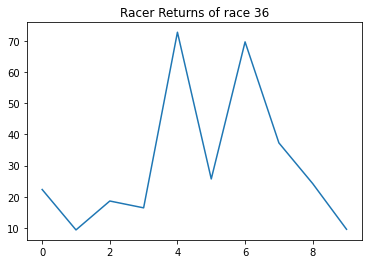

Race complete!
At race 36, finalist model is Model#(4) with episode reward 72.9
carrying following Model numbers: [4, 6]
Starting filling buffer: 37...


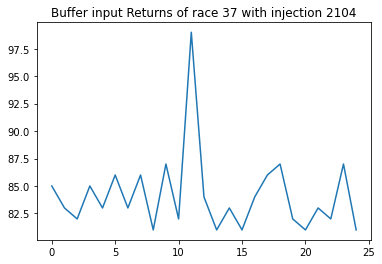

Training starts...
Buufer size: 50316, Starting race 37


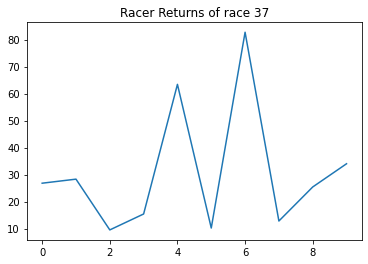

Race complete!
At race 37, finalist model is Model#(6) with episode reward 82.7
carrying following Model numbers: [6]
Starting filling buffer: 38...


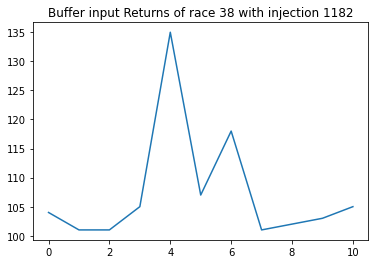

Training starts...
Buufer size: 51498, Starting race 38


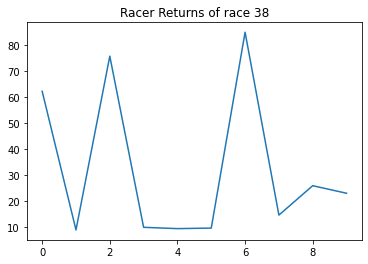

Race complete!
At race 38, finalist model is Model#(6) with episode reward 84.9
carrying following Model numbers: [2, 6]
Starting filling buffer: 39...


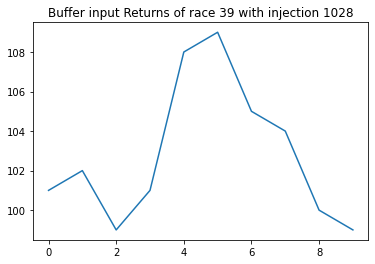

Training starts...
Buufer size: 52526, Starting race 39


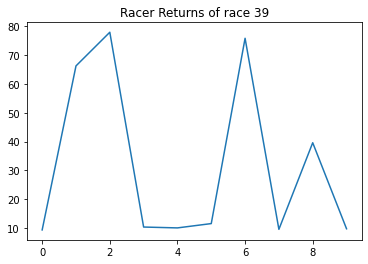

Race complete!
At race 39, finalist model is Model#(2) with episode reward 78.0
carrying following Model numbers: [2, 6]
Starting filling buffer: 40...


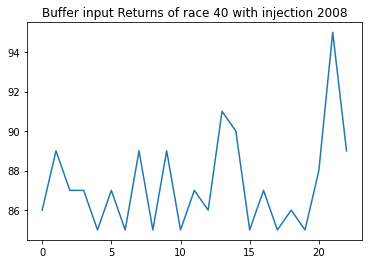

Training starts...
Buufer size: 54534, Starting race 40


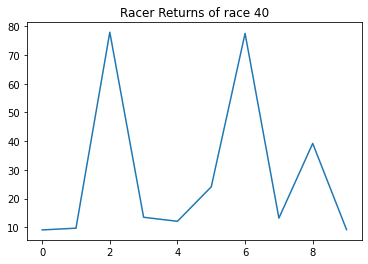

Race complete!
At race 40, finalist model is Model#(2) with episode reward 77.9
carrying following Model numbers: [2, 6]
Starting filling buffer: 41...


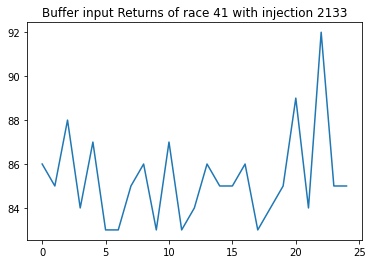

Training starts...
Buufer size: 56667, Starting race 41


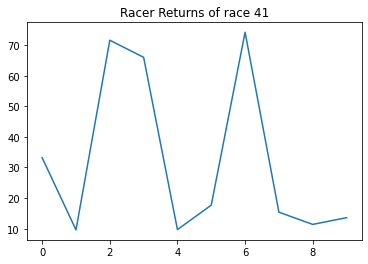

Race complete!
At race 41, finalist model is Model#(6) with episode reward 74.2
carrying following Model numbers: [2, 6]
Starting filling buffer: 42...


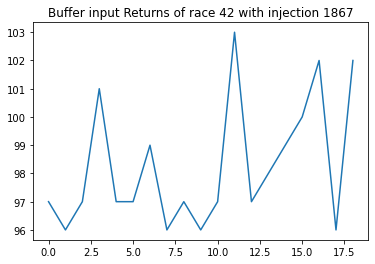

Training starts...
Buufer size: 58534, Starting race 42


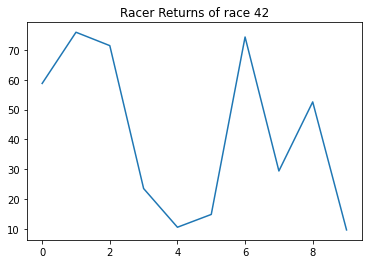

Race complete!
At race 42, finalist model is Model#(1) with episode reward 76.0
carrying following Model numbers: [1, 6]
Starting filling buffer: 43...


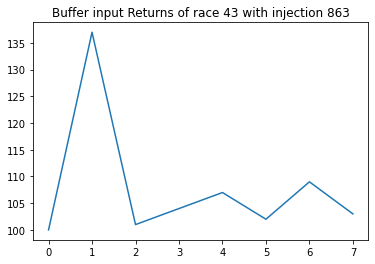

Training starts...
Buufer size: 59397, Starting race 43


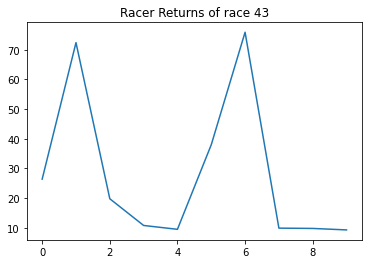

Race complete!
At race 43, finalist model is Model#(6) with episode reward 75.9
carrying following Model numbers: [1, 6]
Starting filling buffer: 44...


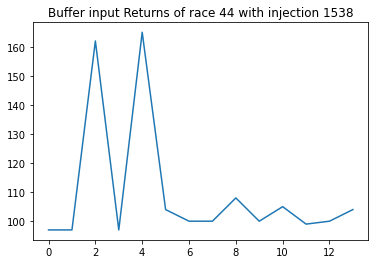

Training starts...
Buufer size: 60935, Starting race 44


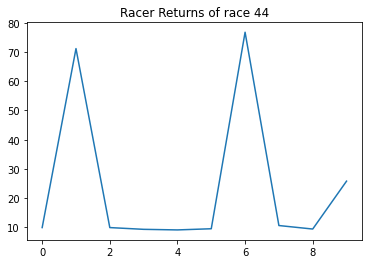

Race complete!
At race 44, finalist model is Model#(6) with episode reward 76.8
carrying following Model numbers: [1, 6]
Starting filling buffer: 45...


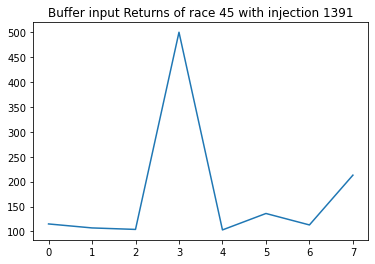

Training starts...
Buufer size: 62326, Starting race 45


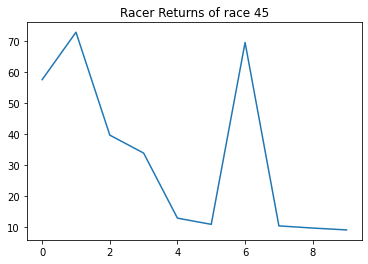

Race complete!
At race 45, finalist model is Model#(1) with episode reward 72.9
carrying following Model numbers: [1, 6]
Starting filling buffer: 46...


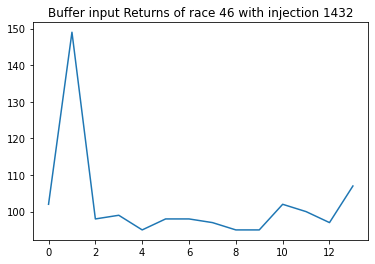

Training starts...
Buufer size: 63758, Starting race 46


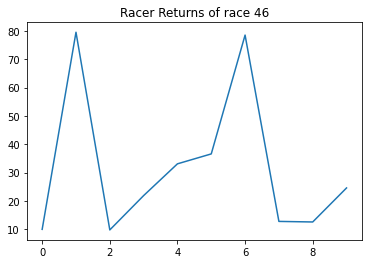

Race complete!
At race 46, finalist model is Model#(1) with episode reward 79.5
carrying following Model numbers: [1, 6]
Starting filling buffer: 47...


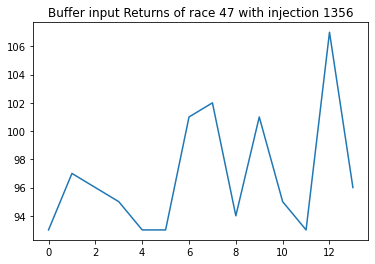

Training starts...
Buufer size: 65114, Starting race 47


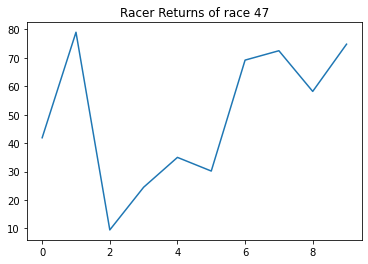

Race complete!
At race 47, finalist model is Model#(1) with episode reward 79.0
carrying following Model numbers: [1, 9]
Starting filling buffer: 48...


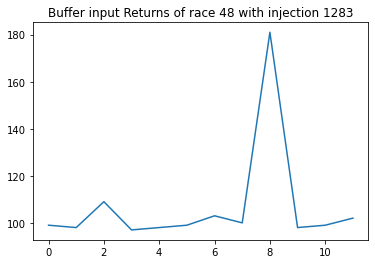

Training starts...
Buufer size: 66397, Starting race 48


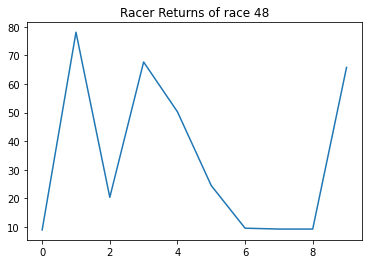

Race complete!
At race 48, finalist model is Model#(1) with episode reward 78.1
carrying following Model numbers: [1, 3]
Starting filling buffer: 49...


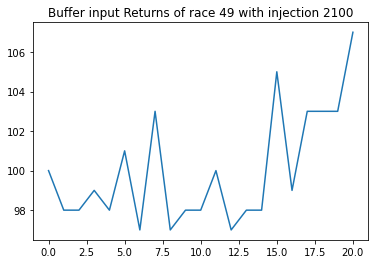

Training starts...
Buufer size: 68497, Starting race 49


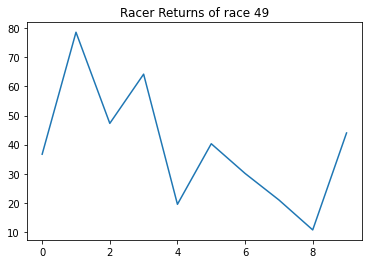

Race complete!
At race 49, finalist model is Model#(1) with episode reward 78.6
carrying following Model numbers: [1]
Starting filling buffer: 50...


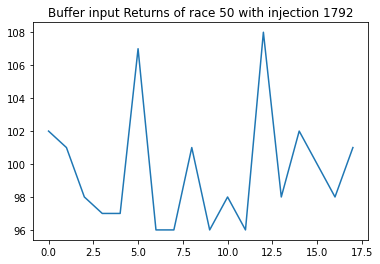

Training starts...
Buufer size: 70289, Starting race 50


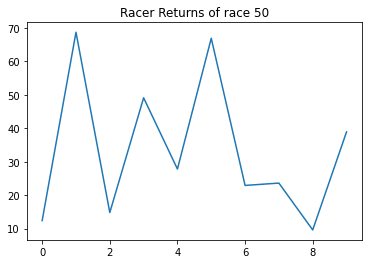

Race complete!
At race 50, finalist model is Model#(1) with episode reward 68.7
carrying following Model numbers: [1, 5]
Starting filling buffer: 51...


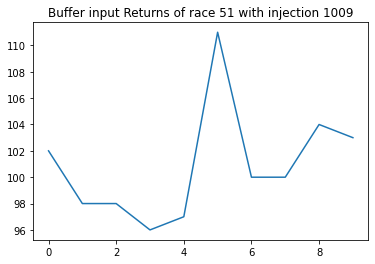

Training starts...
Buufer size: 71298, Starting race 51


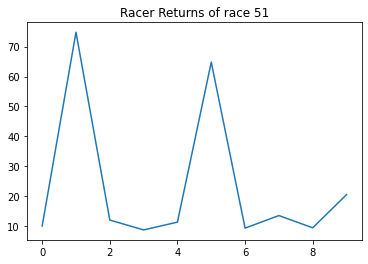

Race complete!
At race 51, finalist model is Model#(1) with episode reward 74.8
carrying following Model numbers: [1, 5]
Starting filling buffer: 52...


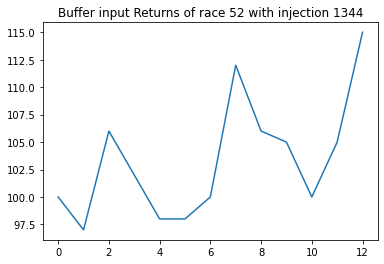

Training starts...
Buufer size: 72642, Starting race 52


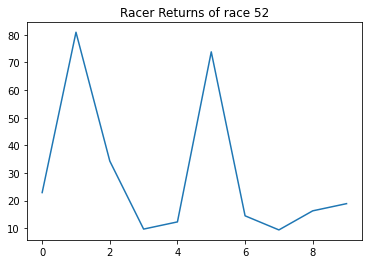

Race complete!
At race 52, finalist model is Model#(1) with episode reward 80.9
carrying following Model numbers: [1, 5]
Starting filling buffer: 53...


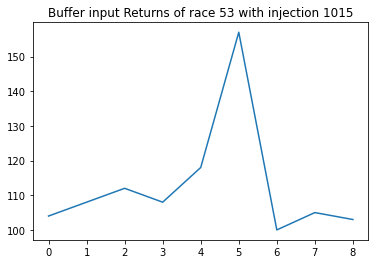

Training starts...
Buufer size: 73657, Starting race 53


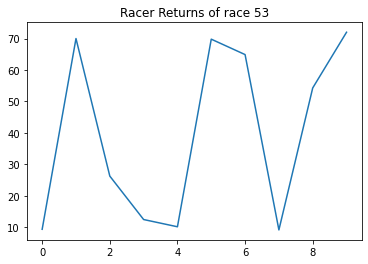

Race complete!
At race 53, finalist model is Model#(9) with episode reward 72.0
carrying following Model numbers: [1, 9]
Starting filling buffer: 54...


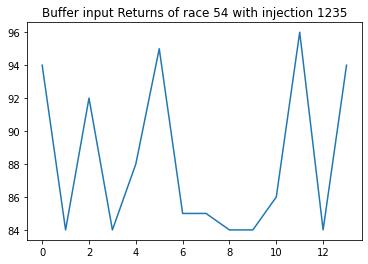

Training starts...
Buufer size: 74892, Starting race 54


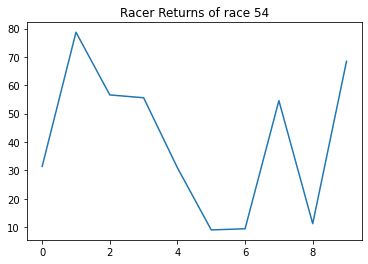

Race complete!
At race 54, finalist model is Model#(1) with episode reward 78.7
carrying following Model numbers: [1, 9]
Starting filling buffer: 55...


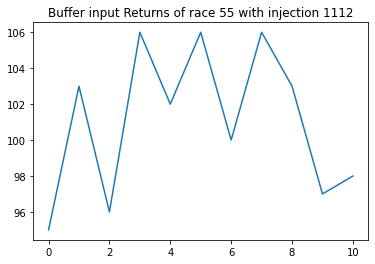

Training starts...
Buufer size: 76004, Starting race 55


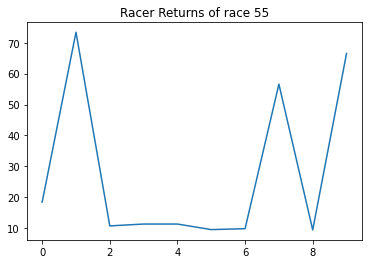

Race complete!
At race 55, finalist model is Model#(1) with episode reward 73.4
carrying following Model numbers: [1, 9]
Starting filling buffer: 56...


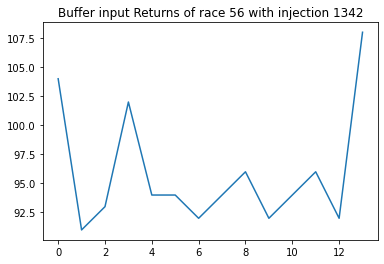

Training starts...
Buufer size: 77346, Starting race 56


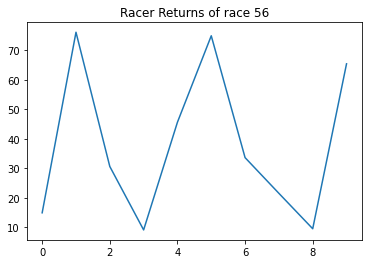

Race complete!
At race 56, finalist model is Model#(1) with episode reward 76.1
carrying following Model numbers: [1, 5]
Starting filling buffer: 57...


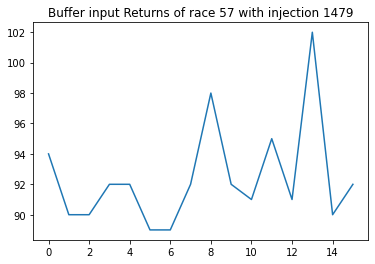

Training starts...
Buufer size: 78825, Starting race 57


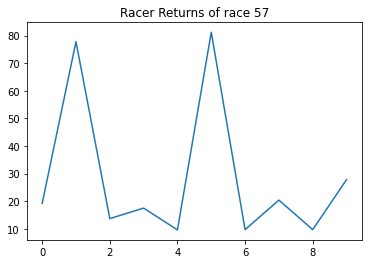

Race complete!
At race 57, finalist model is Model#(5) with episode reward 81.2
carrying following Model numbers: [1, 5]
Starting filling buffer: 58...


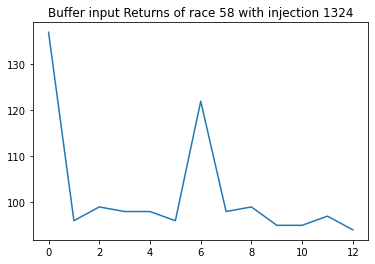

Training starts...
Buufer size: 80149, Starting race 58


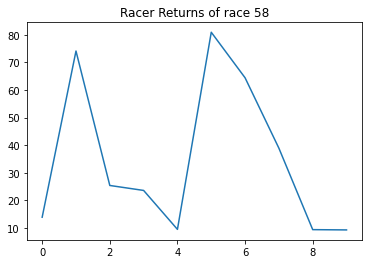

Race complete!
At race 58, finalist model is Model#(5) with episode reward 80.9
carrying following Model numbers: [1, 5]
Starting filling buffer: 59...


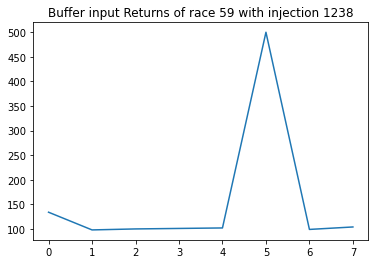

Training starts...
Buufer size: 81387, Starting race 59


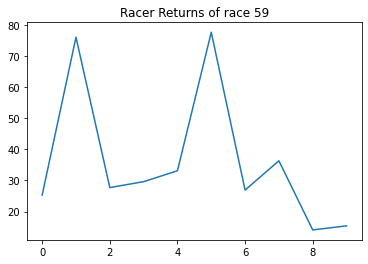

Race complete!
At race 59, finalist model is Model#(5) with episode reward 77.6
carrying following Model numbers: [1, 5]
Starting filling buffer: 60...


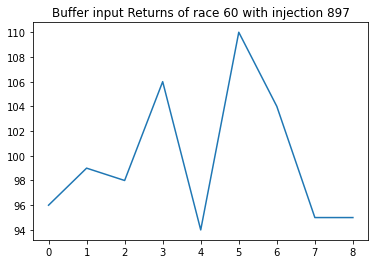

Training starts...
Buufer size: 82284, Starting race 60


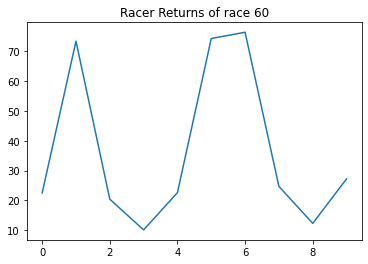

Race complete!
At race 60, finalist model is Model#(6) with episode reward 76.4
carrying following Model numbers: [5, 6]
Starting filling buffer: 61...


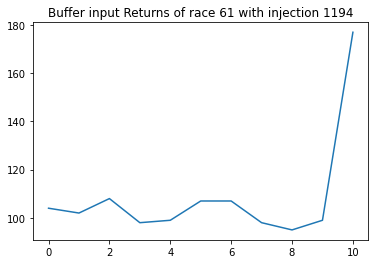

Training starts...
Buufer size: 83478, Starting race 61


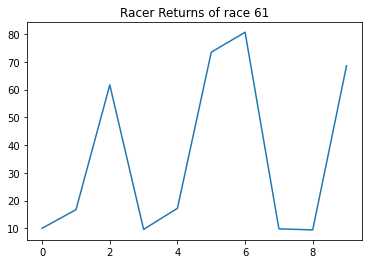

Race complete!
At race 61, finalist model is Model#(6) with episode reward 80.7
carrying following Model numbers: [5, 6]
Starting filling buffer: 62...


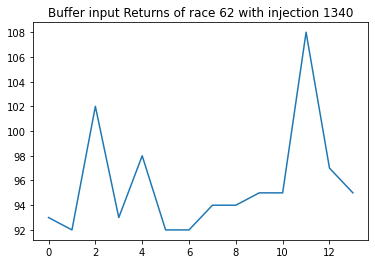

Training starts...
Buufer size: 84818, Starting race 62


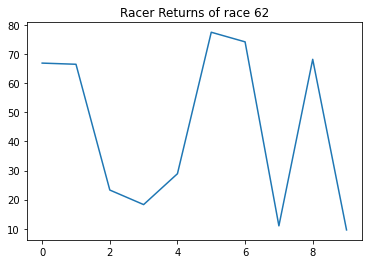

Race complete!
At race 62, finalist model is Model#(5) with episode reward 77.5
carrying following Model numbers: [5, 6]
Starting filling buffer: 63...


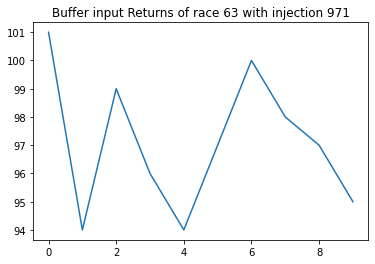

Training starts...
Buufer size: 85789, Starting race 63


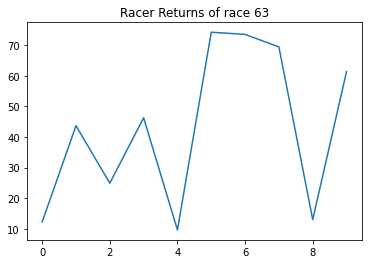

Race complete!
At race 63, finalist model is Model#(5) with episode reward 74.3
carrying following Model numbers: [5, 6]
Starting filling buffer: 64...


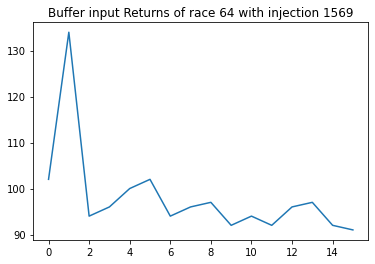

Training starts...
Buufer size: 87358, Starting race 64


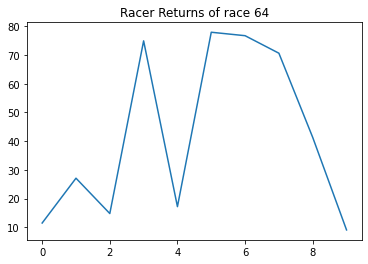

Race complete!
At race 64, finalist model is Model#(5) with episode reward 77.9
carrying following Model numbers: [5, 6]
Starting filling buffer: 65...


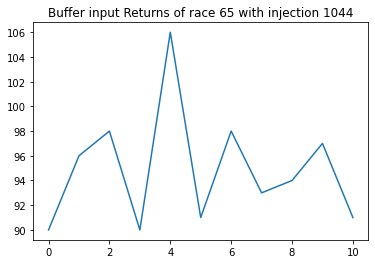

Training starts...
Buufer size: 88402, Starting race 65


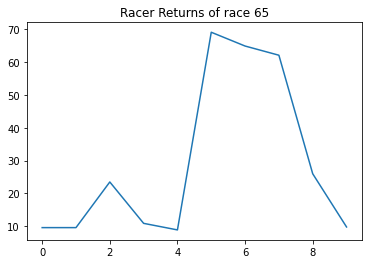

Race complete!
At race 65, finalist model is Model#(5) with episode reward 69.1
carrying following Model numbers: [5, 6]
Starting filling buffer: 66...


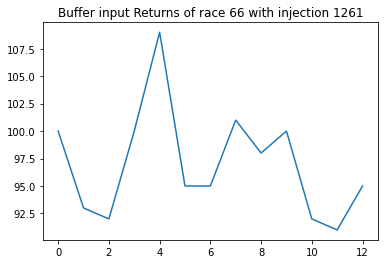

Training starts...
Buufer size: 89663, Starting race 66


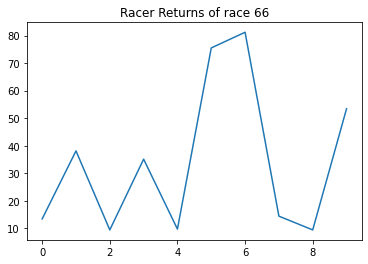

Race complete!
At race 66, finalist model is Model#(6) with episode reward 81.2
carrying following Model numbers: [5, 6]
Starting filling buffer: 67...


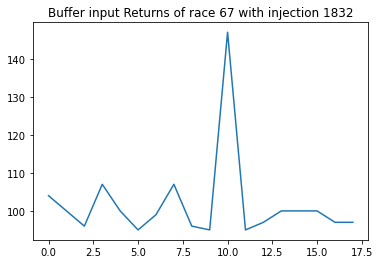

Training starts...
Buufer size: 91495, Starting race 67


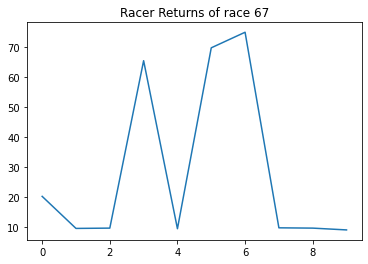

Race complete!
At race 67, finalist model is Model#(6) with episode reward 75.0
carrying following Model numbers: [5, 6]
Starting filling buffer: 68...


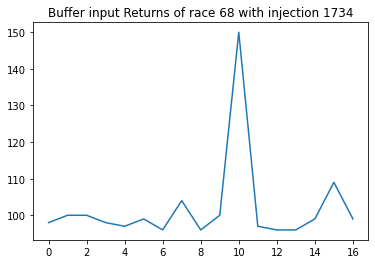

Training starts...
Buufer size: 93229, Starting race 68


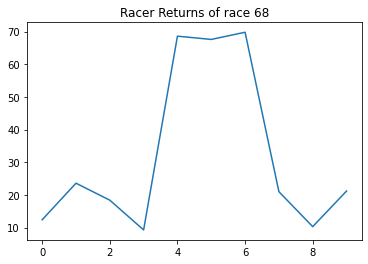

Race complete!
At race 68, finalist model is Model#(6) with episode reward 69.8
carrying following Model numbers: [4, 6]
Starting filling buffer: 69...


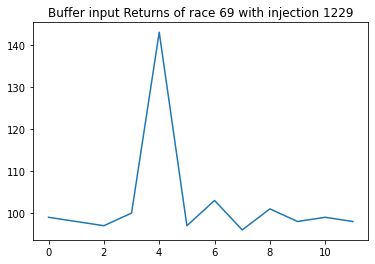

Training starts...
Buufer size: 94458, Starting race 69


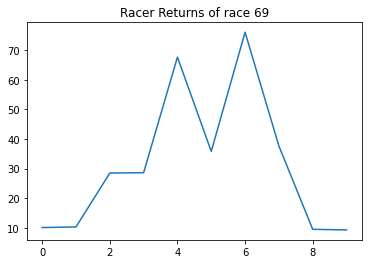

Race complete!
At race 69, finalist model is Model#(6) with episode reward 76.0
carrying following Model numbers: [4, 6]
Starting filling buffer: 70...


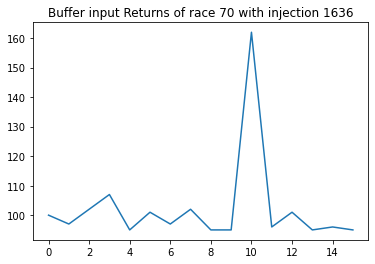

Training starts...
Buufer size: 96094, Starting race 70


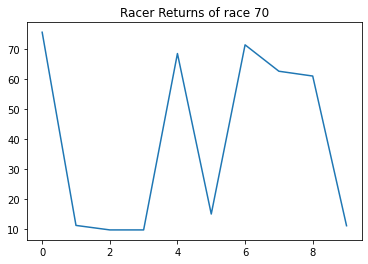

Race complete!
At race 70, finalist model is Model#(0) with episode reward 75.7
carrying following Model numbers: [0, 6]
Starting filling buffer: 71...


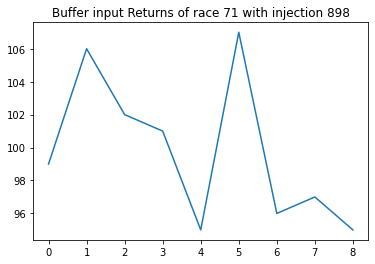

Training starts...
Buufer size: 96992, Starting race 71


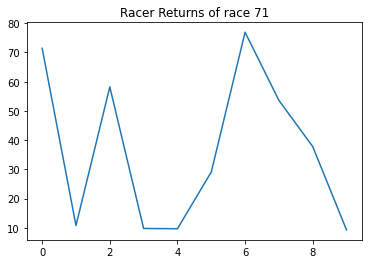

Race complete!
At race 71, finalist model is Model#(6) with episode reward 76.9
carrying following Model numbers: [0, 6]
Starting filling buffer: 72...


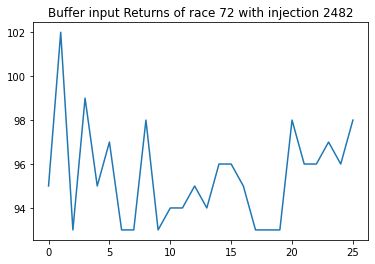

Training starts...
Buufer size: 99474, Starting race 72


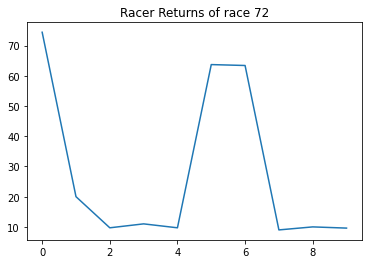

Race complete!
At race 72, finalist model is Model#(0) with episode reward 74.4
carrying following Model numbers: [0, 5]
Starting filling buffer: 73...


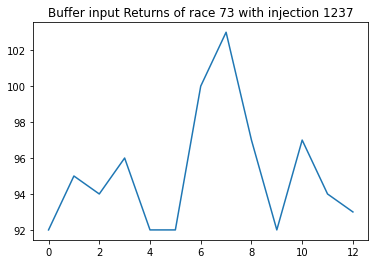

Training starts...
Buufer size: 100711, Starting race 73


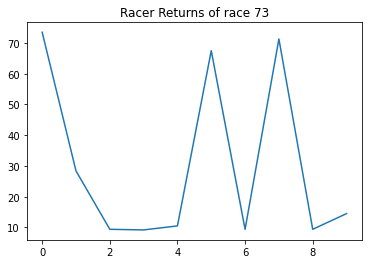

Race complete!
At race 73, finalist model is Model#(0) with episode reward 73.5
carrying following Model numbers: [0, 7]
Starting filling buffer: 74...


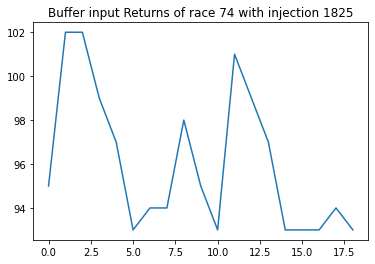

Training starts...
Buufer size: 102536, Starting race 74


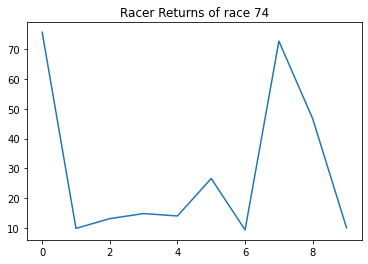

Race complete!
At race 74, finalist model is Model#(0) with episode reward 75.8
carrying following Model numbers: [0, 7]
Starting filling buffer: 75...


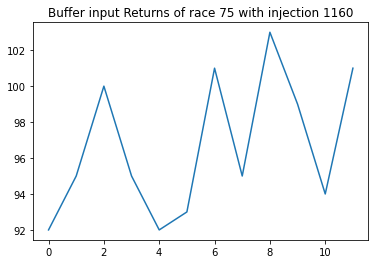

Training starts...
Buufer size: 103696, Starting race 75


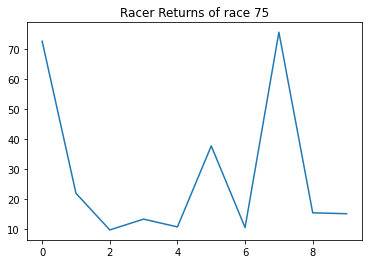

Race complete!
At race 75, finalist model is Model#(7) with episode reward 75.6
carrying following Model numbers: [0, 7]
Starting filling buffer: 76...


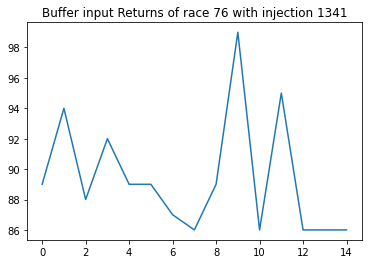

Training starts...
Buufer size: 105037, Starting race 76


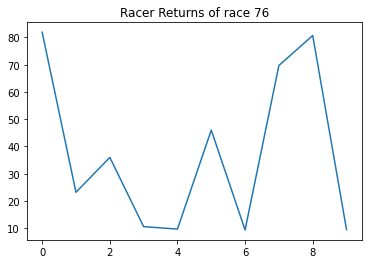

Race complete!
At race 76, finalist model is Model#(0) with episode reward 81.9
carrying following Model numbers: [0, 8]
Starting filling buffer: 77...


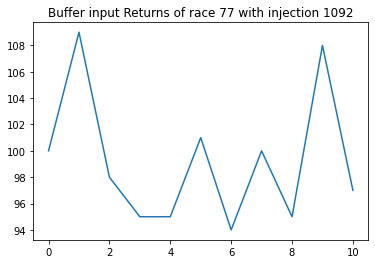

Training starts...
Buufer size: 106129, Starting race 77


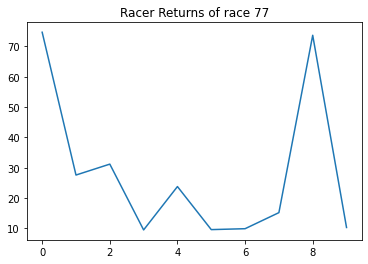

Race complete!
At race 77, finalist model is Model#(0) with episode reward 74.7
carrying following Model numbers: [0, 8]
Starting filling buffer: 78...


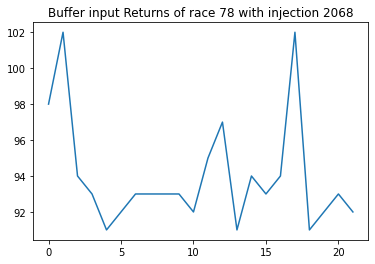

Training starts...
Buufer size: 108197, Starting race 78


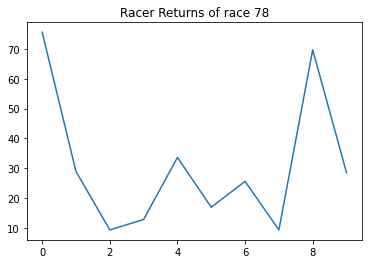

Race complete!
At race 78, finalist model is Model#(0) with episode reward 75.6
carrying following Model numbers: [0, 8]
Starting filling buffer: 79...


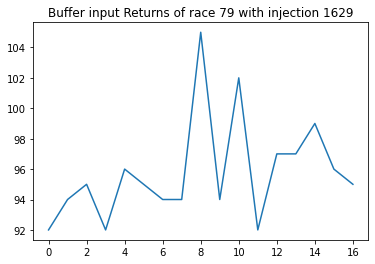

Training starts...
Buufer size: 109826, Starting race 79


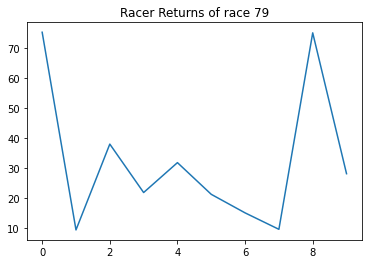

Race complete!
At race 79, finalist model is Model#(0) with episode reward 75.4
carrying following Model numbers: [0, 8]
Starting filling buffer: 80...


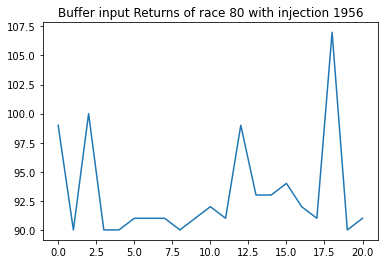

Training starts...
Buufer size: 111782, Starting race 80


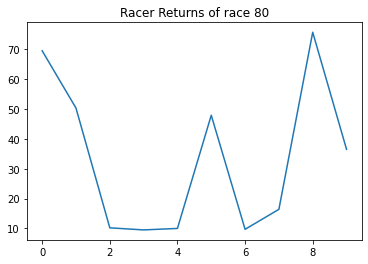

Race complete!
At race 80, finalist model is Model#(8) with episode reward 75.7
carrying following Model numbers: [0, 8]
Starting filling buffer: 81...


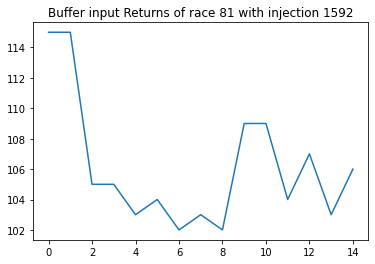

Training starts...
Buufer size: 113374, Starting race 81


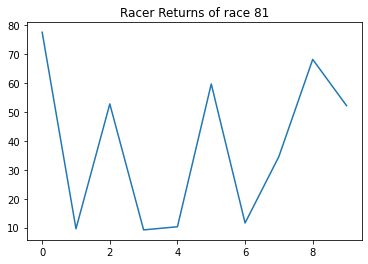

Race complete!
At race 81, finalist model is Model#(0) with episode reward 77.6
carrying following Model numbers: [0, 8]
Starting filling buffer: 82...


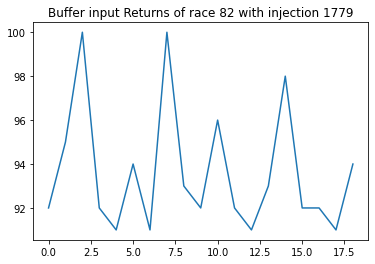

Training starts...
Buufer size: 115153, Starting race 82


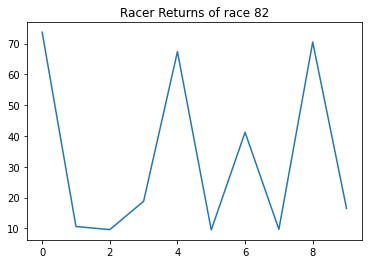

Race complete!
At race 82, finalist model is Model#(0) with episode reward 73.7
carrying following Model numbers: [0, 8]
Starting filling buffer: 83...


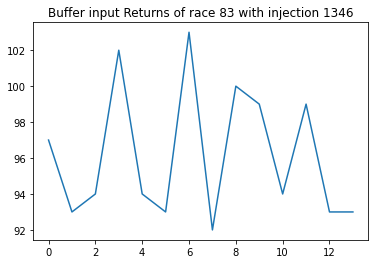

Training starts...
Buufer size: 116499, Starting race 83


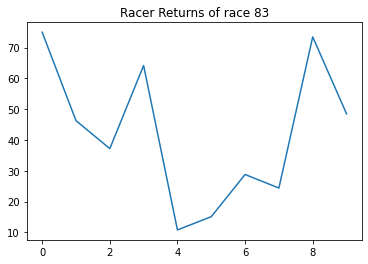

Race complete!
At race 83, finalist model is Model#(0) with episode reward 75.0
carrying following Model numbers: [0, 8]
Starting filling buffer: 84...


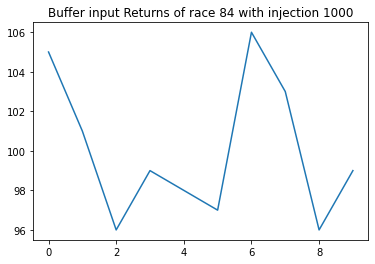

Training starts...
Buufer size: 117499, Starting race 84


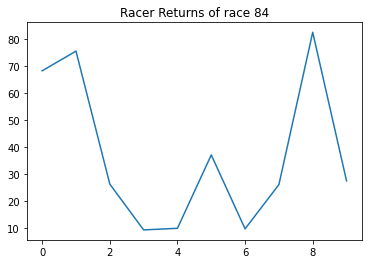

Race complete!
At race 84, finalist model is Model#(8) with episode reward 82.6
carrying following Model numbers: [1, 8]
Starting filling buffer: 85...


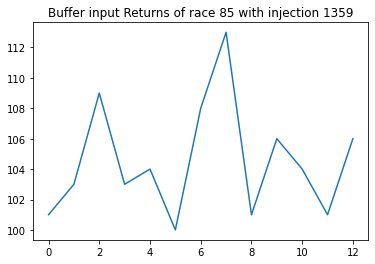

Training starts...
Buufer size: 118858, Starting race 85


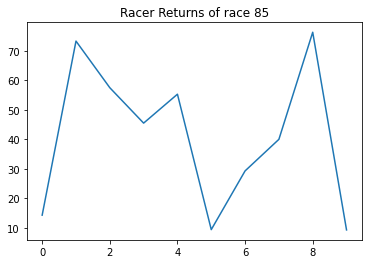

Race complete!
At race 85, finalist model is Model#(8) with episode reward 76.3
carrying following Model numbers: [1, 8]
Starting filling buffer: 86...


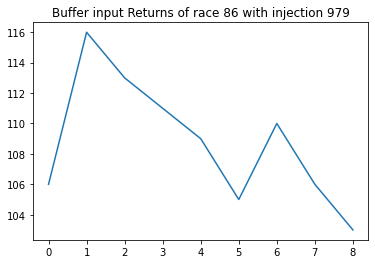

Training starts...
Buufer size: 119837, Starting race 86


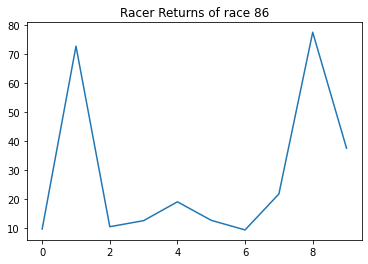

Race complete!
At race 86, finalist model is Model#(8) with episode reward 77.6
carrying following Model numbers: [1, 8]
Starting filling buffer: 87...


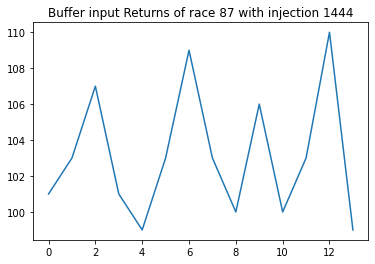

Training starts...
Buufer size: 121281, Starting race 87


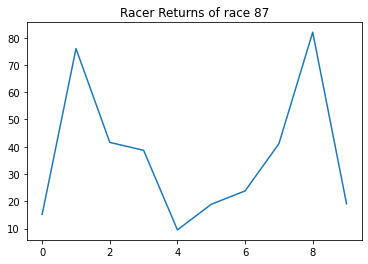

Race complete!
At race 87, finalist model is Model#(8) with episode reward 82.0
carrying following Model numbers: [1, 8]
Starting filling buffer: 88...


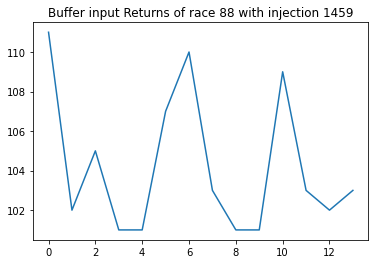

Training starts...
Buufer size: 122740, Starting race 88


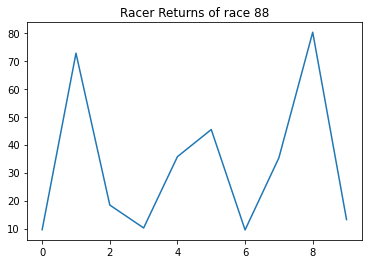

Race complete!
At race 88, finalist model is Model#(8) with episode reward 80.2
carrying following Model numbers: [1, 8]
Starting filling buffer: 89...


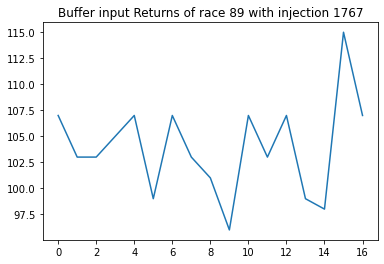

Training starts...
Buufer size: 124507, Starting race 89


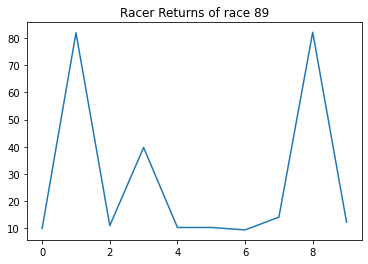

Race complete!
At race 89, finalist model is Model#(8) with episode reward 82.2
carrying following Model numbers: [1, 8]
Starting filling buffer: 90...


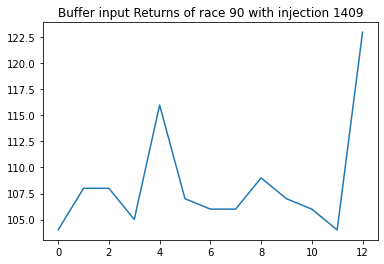

Training starts...
Buufer size: 125916, Starting race 90


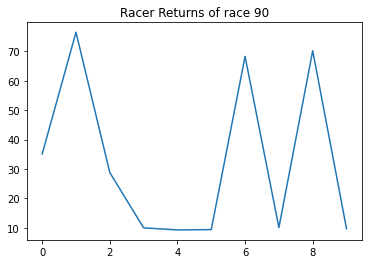

Race complete!
At race 90, finalist model is Model#(1) with episode reward 76.5
carrying following Model numbers: [1, 8]
Starting filling buffer: 91...


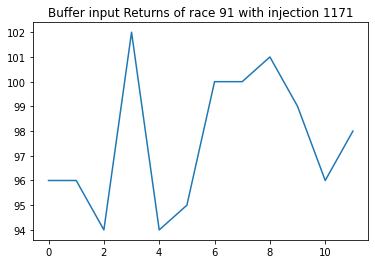

Training starts...
Buufer size: 127087, Starting race 91


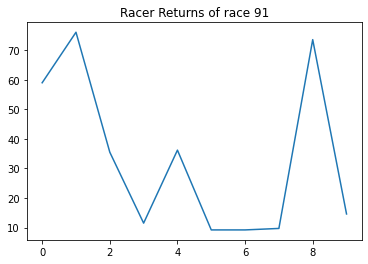

Race complete!
At race 91, finalist model is Model#(1) with episode reward 76.1
carrying following Model numbers: [1, 8]
Starting filling buffer: 92...


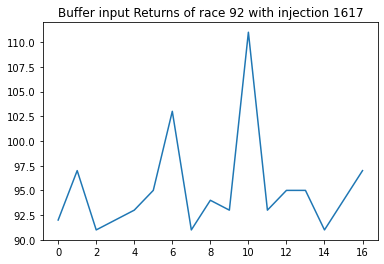

Training starts...
Buufer size: 128704, Starting race 92


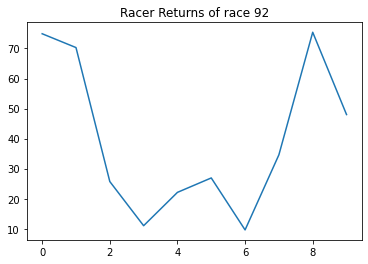

Race complete!
At race 92, finalist model is Model#(8) with episode reward 75.4
carrying following Model numbers: [0, 8]
Starting filling buffer: 93...


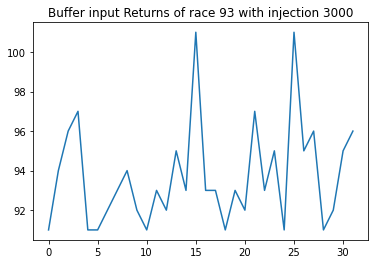

Training starts...
Buufer size: 131704, Starting race 93


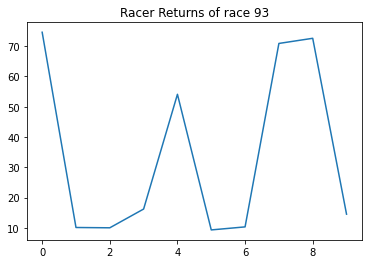

Race complete!
At race 93, finalist model is Model#(0) with episode reward 74.6
carrying following Model numbers: [0, 8]
Starting filling buffer: 94...


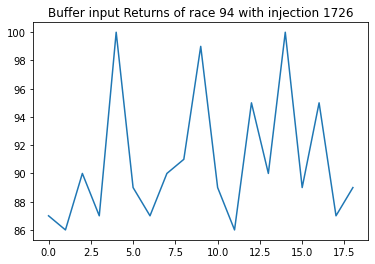

Training starts...
Buufer size: 133430, Starting race 94


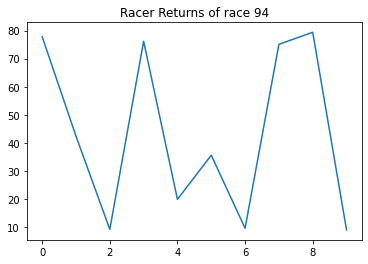

Race complete!
At race 94, finalist model is Model#(8) with episode reward 79.4
carrying following Model numbers: [0, 8]
Starting filling buffer: 95...


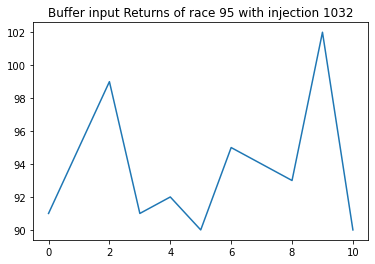

Training starts...
Buufer size: 134462, Starting race 95


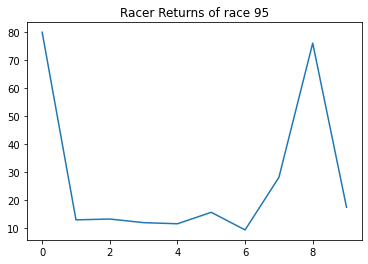

Race complete!
At race 95, finalist model is Model#(0) with episode reward 80.0
carrying following Model numbers: [0, 8]
Starting filling buffer: 96...


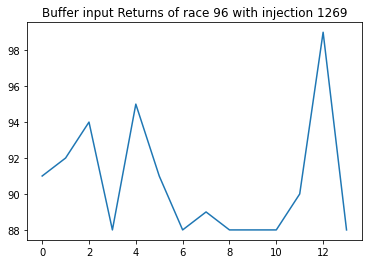

Training starts...
Buufer size: 135731, Starting race 96


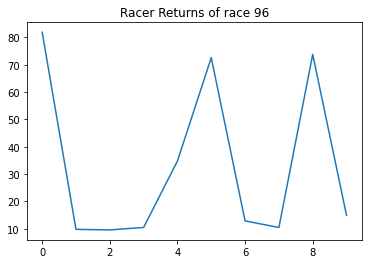

Race complete!
At race 96, finalist model is Model#(0) with episode reward 81.9
carrying following Model numbers: [0, 8]
Starting filling buffer: 97...


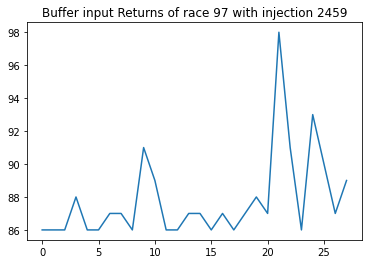

Training starts...
Buufer size: 138190, Starting race 97


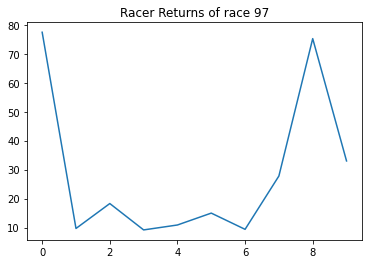

Race complete!
At race 97, finalist model is Model#(0) with episode reward 77.4
carrying following Model numbers: [0, 8]
Starting filling buffer: 98...


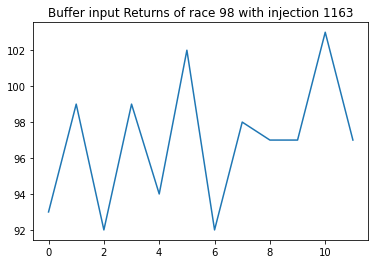

Training starts...
Buufer size: 139353, Starting race 98


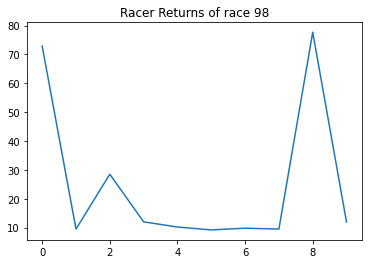

Race complete!
At race 98, finalist model is Model#(8) with episode reward 77.7
carrying following Model numbers: [0, 8]
Starting filling buffer: 99...


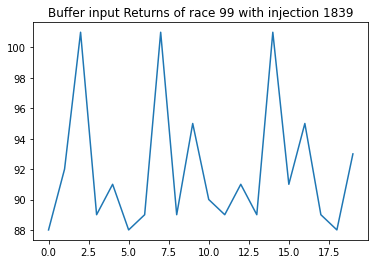

Training starts...
Buufer size: 141192, Starting race 99


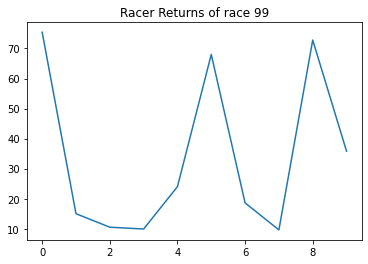

Race complete!
At race 99, finalist model is Model#(0) with episode reward 75.4
carrying following Model numbers: [0, 8]
Starting filling buffer: 100...


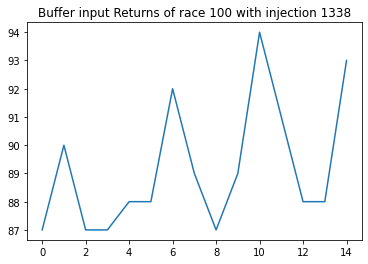

Training starts...
Buufer size: 142530, Starting race 100


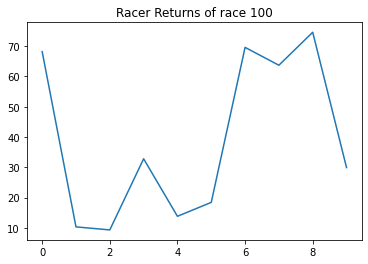

Race complete!
At race 100, finalist model is Model#(8) with episode reward 74.6
carrying following Model numbers: [6, 8]
Starting filling buffer: 101...


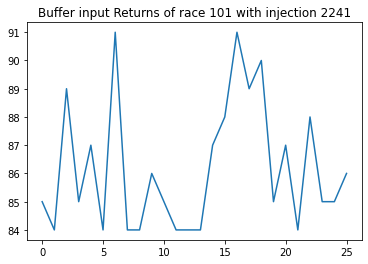

Training starts...
Buufer size: 144771, Starting race 101


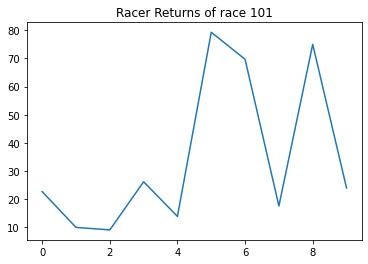

Race complete!
At race 101, finalist model is Model#(5) with episode reward 79.3
carrying following Model numbers: [5, 8]
Starting filling buffer: 102...


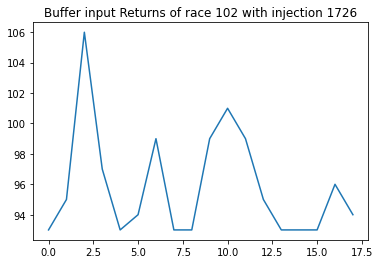

Training starts...
Buufer size: 146497, Starting race 102


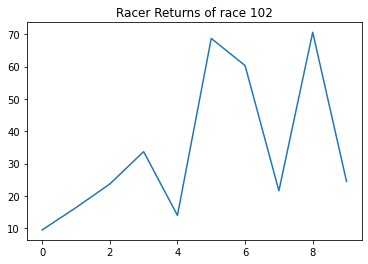

Race complete!
At race 102, finalist model is Model#(8) with episode reward 70.6
carrying following Model numbers: [5, 8]
Starting filling buffer: 103...


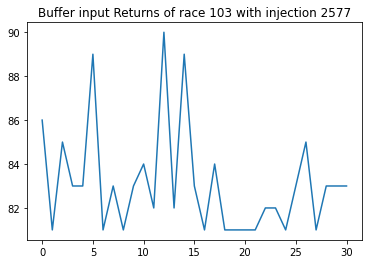

Training starts...
Buufer size: 149074, Starting race 103


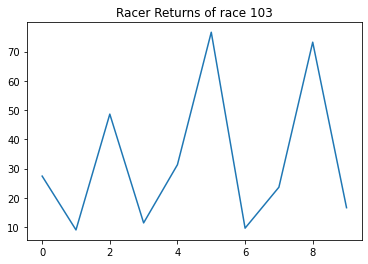

Race complete!
At race 103, finalist model is Model#(5) with episode reward 76.6
carrying following Model numbers: [5, 8]
Starting filling buffer: 104...


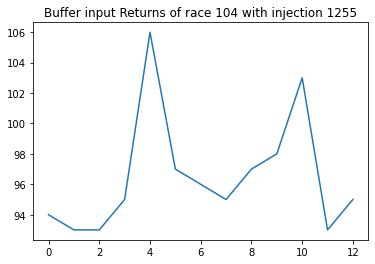

Training starts...
Buufer size: 150329, Starting race 104


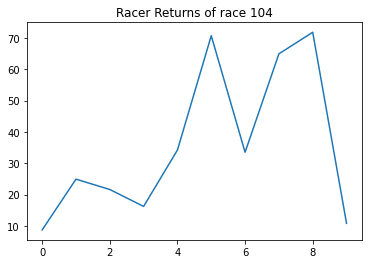

Race complete!
At race 104, finalist model is Model#(8) with episode reward 71.8
carrying following Model numbers: [5, 8]
Starting filling buffer: 105...


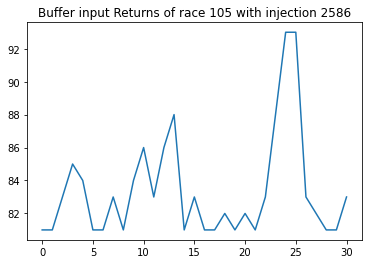

Training starts...
Buufer size: 152915, Starting race 105


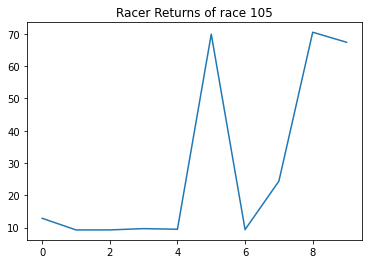

Race complete!
At race 105, finalist model is Model#(8) with episode reward 70.5
carrying following Model numbers: [5, 8]
Starting filling buffer: 106...


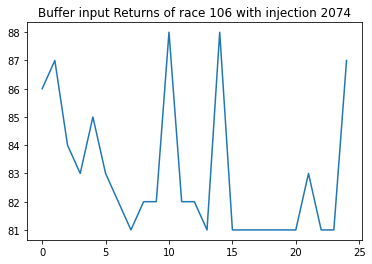

Training starts...
Buufer size: 154989, Starting race 106


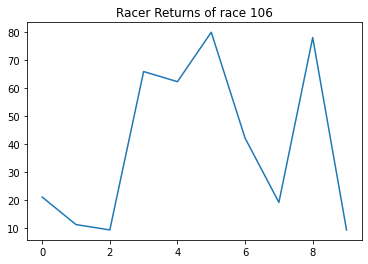

Race complete!
At race 106, finalist model is Model#(5) with episode reward 79.8
carrying following Model numbers: [5, 8]
Starting filling buffer: 107...


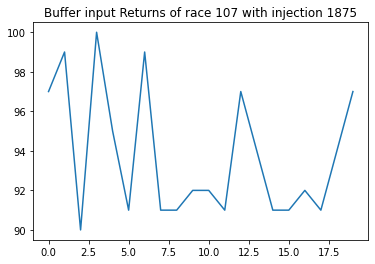

Training starts...
Buufer size: 156864, Starting race 107


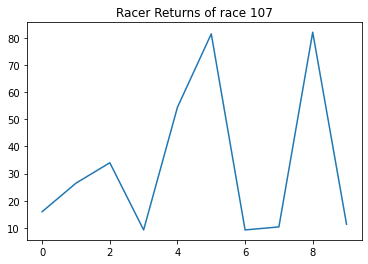

Race complete!
At race 107, finalist model is Model#(8) with episode reward 82.0
carrying following Model numbers: [5, 8]
Starting filling buffer: 108...


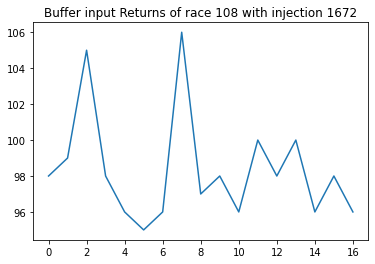

Training starts...
Buufer size: 158536, Starting race 108


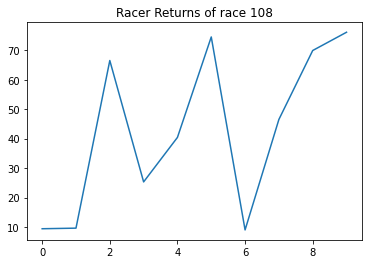

Race complete!
At race 108, finalist model is Model#(9) with episode reward 76.1
carrying following Model numbers: [5, 9]
Starting filling buffer: 109...


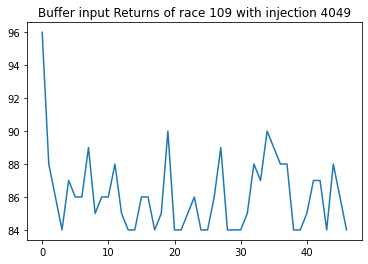

Training starts...
Buufer size: 162585, Starting race 109


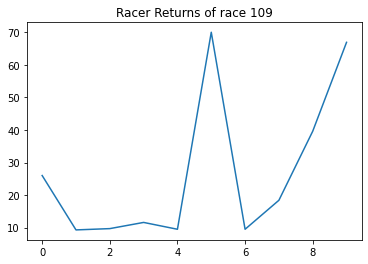

Race complete!
At race 109, finalist model is Model#(5) with episode reward 70.0
carrying following Model numbers: [5, 9]
Starting filling buffer: 110...


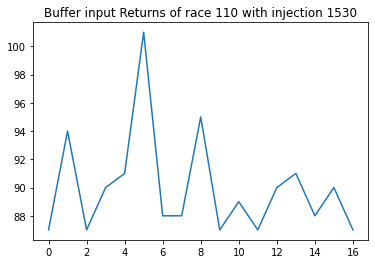

Training starts...
Buufer size: 164115, Starting race 110


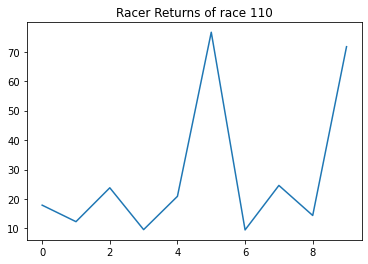

Race complete!
At race 110, finalist model is Model#(5) with episode reward 76.6
carrying following Model numbers: [5, 9]
Starting filling buffer: 111...


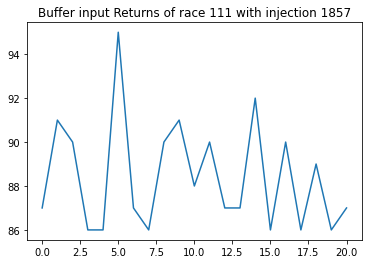

Training starts...
Buufer size: 165972, Starting race 111


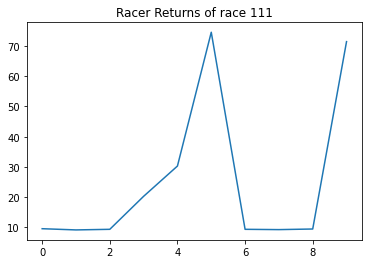

Race complete!
At race 111, finalist model is Model#(5) with episode reward 74.5
carrying following Model numbers: [5, 9]
Starting filling buffer: 112...


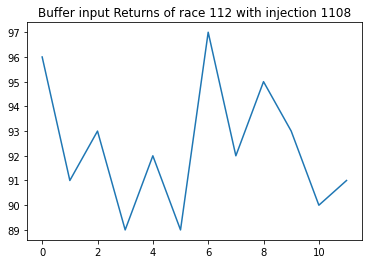

Training starts...
Buufer size: 167080, Starting race 112


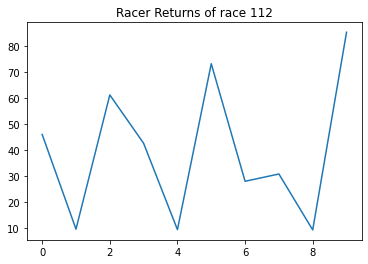

Race complete!
At race 112, finalist model is Model#(9) with episode reward 85.3
carrying following Model numbers: [5, 9]
Starting filling buffer: 113...


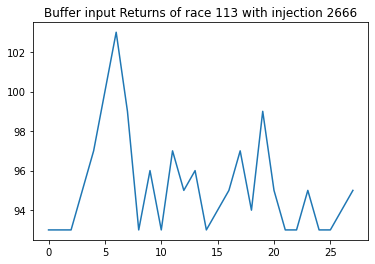

Training starts...
Buufer size: 169746, Starting race 113


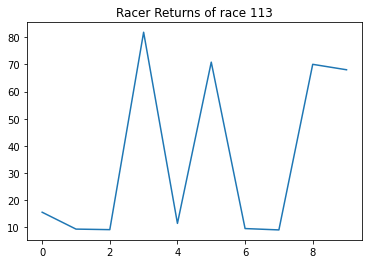

Race complete!
At race 113, finalist model is Model#(3) with episode reward 81.8
carrying following Model numbers: [3, 5]
Starting filling buffer: 114...


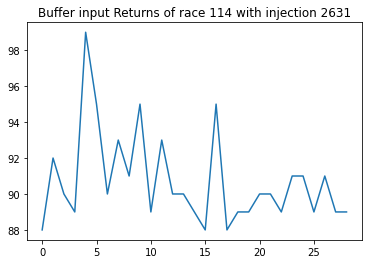

Training starts...
Buufer size: 172377, Starting race 114


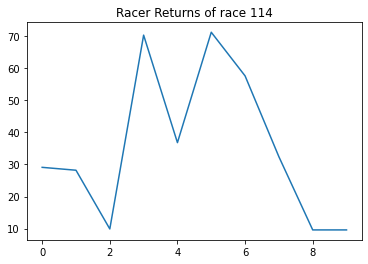

Race complete!
At race 114, finalist model is Model#(5) with episode reward 71.2
carrying following Model numbers: [3, 5]
Starting filling buffer: 115...


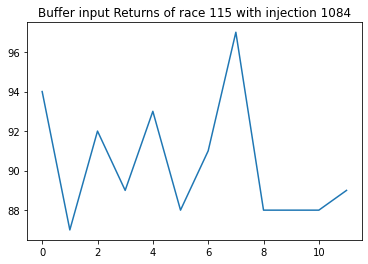

Training starts...
Buufer size: 173461, Starting race 115


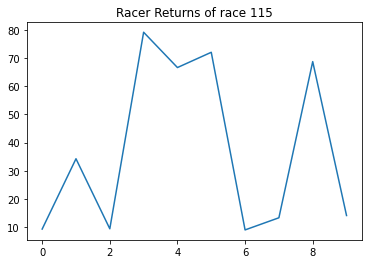

Race complete!
At race 115, finalist model is Model#(3) with episode reward 79.1
carrying following Model numbers: [3, 5]
Starting filling buffer: 116...


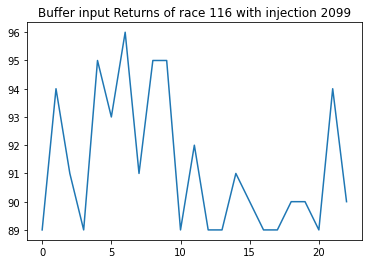

Training starts...
Buufer size: 175560, Starting race 116


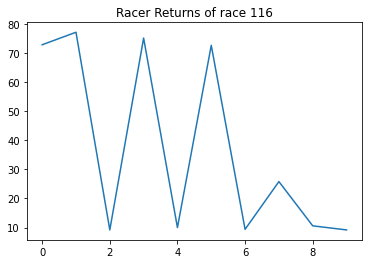

Race complete!
At race 116, finalist model is Model#(1) with episode reward 77.1
carrying following Model numbers: [1, 3]
Starting filling buffer: 117...


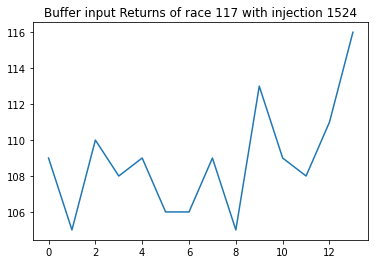

Training starts...
Buufer size: 177084, Starting race 117


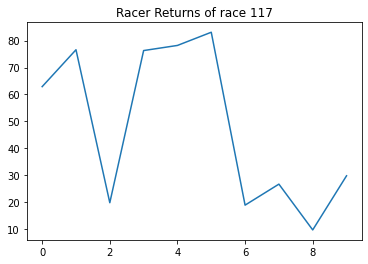

Race complete!
At race 117, finalist model is Model#(5) with episode reward 83.1
carrying following Model numbers: [4, 5]
Starting filling buffer: 118...


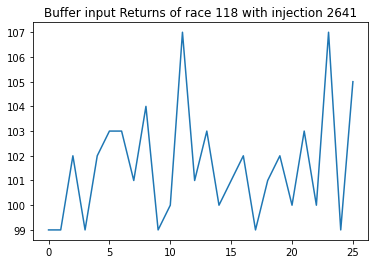

Training starts...
Buufer size: 179725, Starting race 118


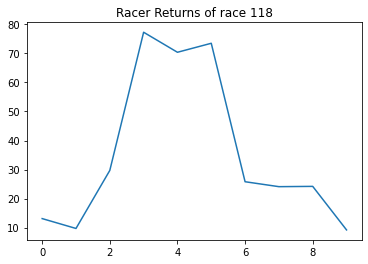

Race complete!
At race 118, finalist model is Model#(3) with episode reward 77.3
carrying following Model numbers: [3, 5]
Starting filling buffer: 119...


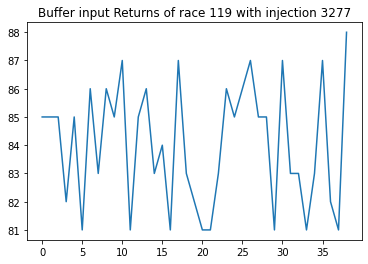

Training starts...
Buufer size: 183002, Starting race 119


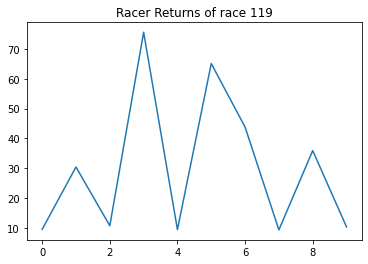

Race complete!
At race 119, finalist model is Model#(3) with episode reward 75.6
carrying following Model numbers: [3, 5]
Starting filling buffer: 120...


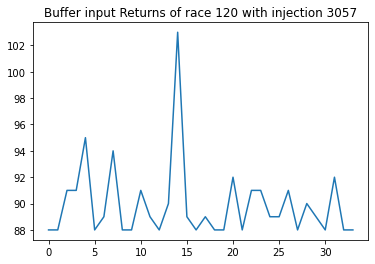

Training starts...
Buufer size: 186059, Starting race 120


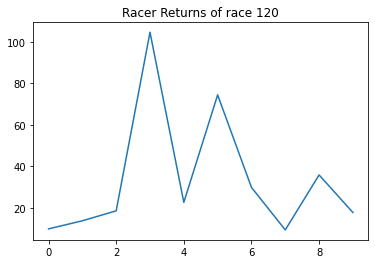

Race complete!
At race 120, finalist model is Model#(3) with episode reward 104.6
carrying following Model numbers: [3]
Starting filling buffer: 121...


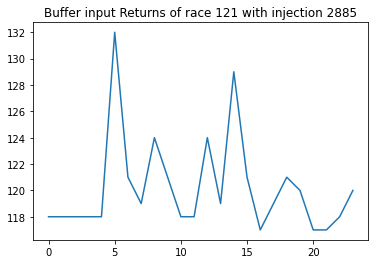

Training starts...
Buufer size: 188944, Starting race 121


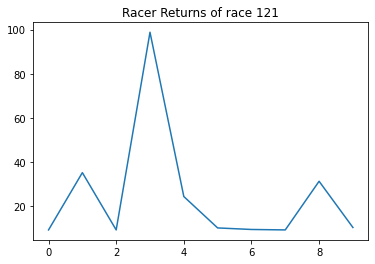

Race complete!
At race 121, finalist model is Model#(3) with episode reward 98.8
carrying following Model numbers: [3]
Starting filling buffer: 122...


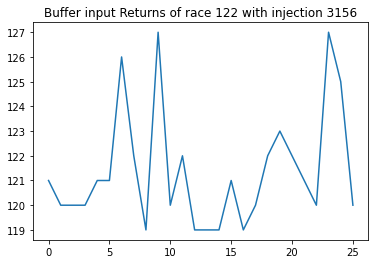

Training starts...
Buufer size: 192100, Starting race 122


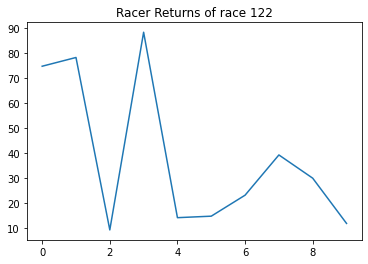

Race complete!
At race 122, finalist model is Model#(3) with episode reward 88.4
carrying following Model numbers: [1, 3]
Starting filling buffer: 123...


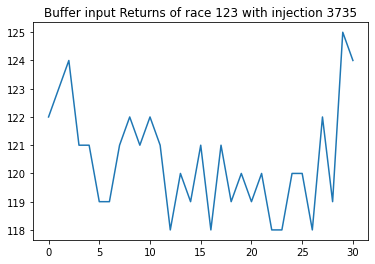

Training starts...
Buufer size: 195835, Starting race 123


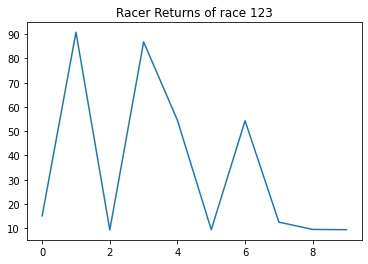

Race complete!
At race 123, finalist model is Model#(1) with episode reward 90.8
carrying following Model numbers: [1, 3]
Starting filling buffer: 124...


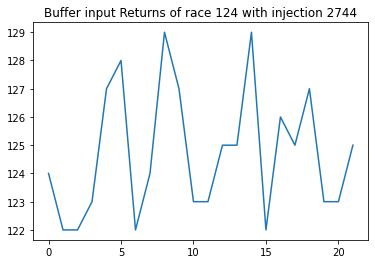

Training starts...
Buufer size: 198579, Starting race 124


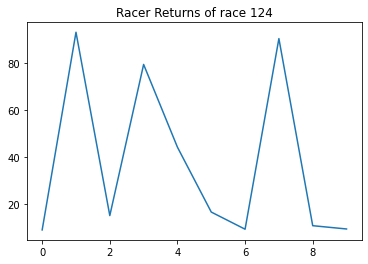

Race complete!
At race 124, finalist model is Model#(1) with episode reward 93.1
carrying following Model numbers: [1, 7]
Starting filling buffer: 125...


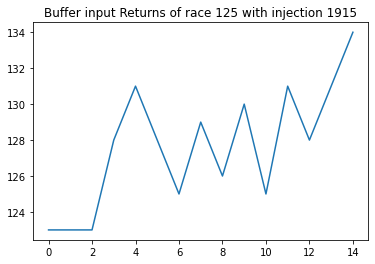

Training starts...
Buufer size: 200494, Starting race 125


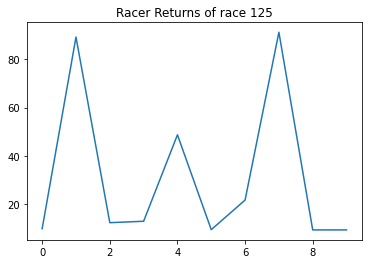

Race complete!
At race 125, finalist model is Model#(7) with episode reward 91.3
carrying following Model numbers: [1, 7]
Starting filling buffer: 126...


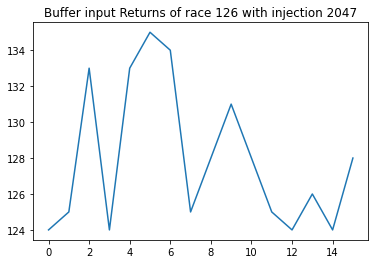

Training starts...
Buufer size: 202541, Starting race 126


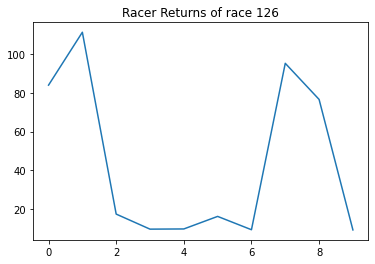

Race complete!
At race 126, finalist model is Model#(1) with episode reward 111.5
carrying following Model numbers: [1, 7]
Starting filling buffer: 127...


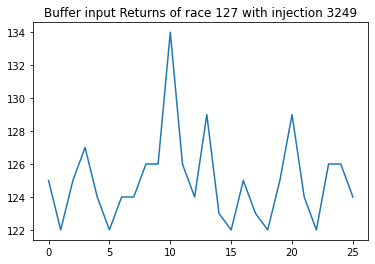

Training starts...
Buufer size: 205790, Starting race 127


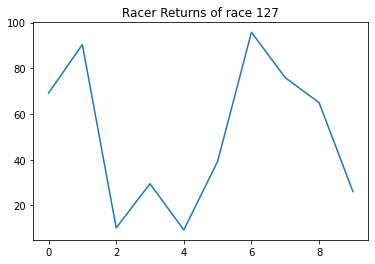

Race complete!
At race 127, finalist model is Model#(6) with episode reward 95.8
carrying following Model numbers: [1, 6]
Starting filling buffer: 128...


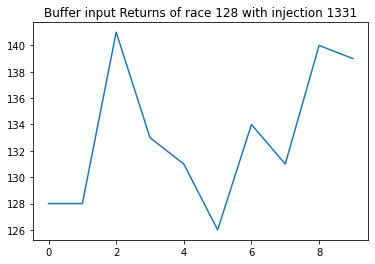

Training starts...
Buufer size: 207121, Starting race 128


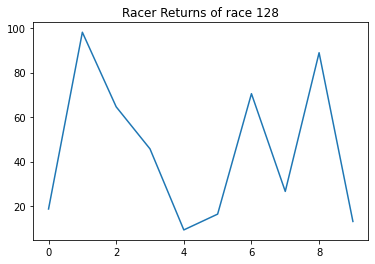

Race complete!
At race 128, finalist model is Model#(1) with episode reward 98.1
carrying following Model numbers: [1, 8]
Starting filling buffer: 129...


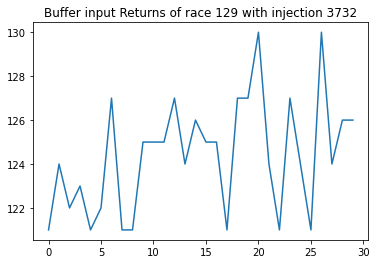

Training starts...
Buufer size: 210853, Starting race 129


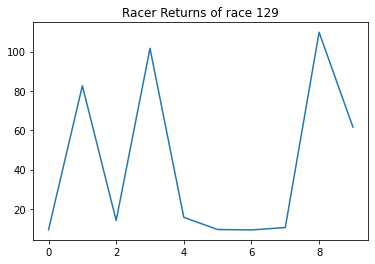

Race complete!
At race 129, finalist model is Model#(8) with episode reward 109.8
carrying following Model numbers: [3, 8]
Starting filling buffer: 130...


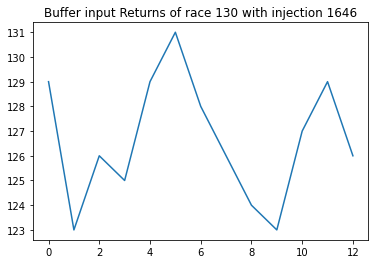

Training starts...
Buufer size: 212499, Starting race 130


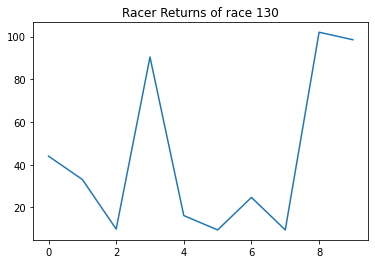

Race complete!
At race 130, finalist model is Model#(8) with episode reward 102.0
carrying following Model numbers: [8, 9]
Starting filling buffer: 131...


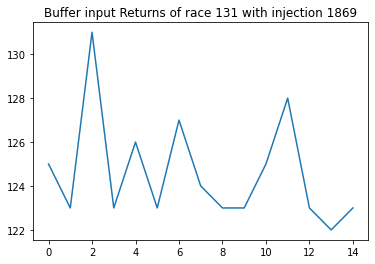

Training starts...
Buufer size: 214368, Starting race 131


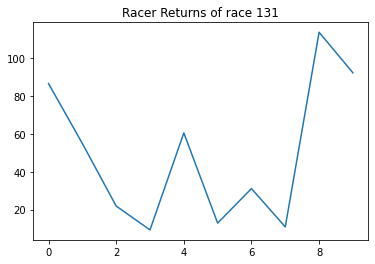

Race complete!
At race 131, finalist model is Model#(8) with episode reward 113.6
carrying following Model numbers: [8]
Starting filling buffer: 132...


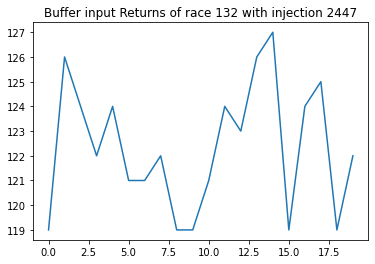

Training starts...
Buufer size: 216815, Starting race 132


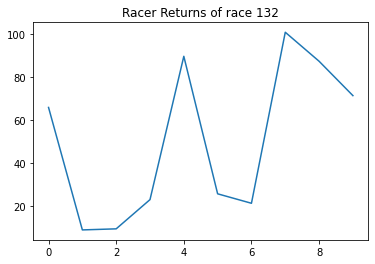

Race complete!
At race 132, finalist model is Model#(7) with episode reward 101.0
carrying following Model numbers: [4, 7]
Starting filling buffer: 133...


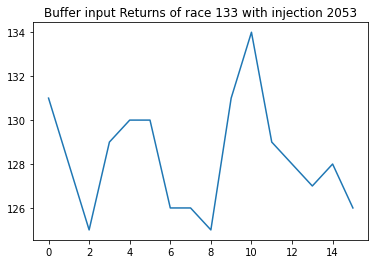

Training starts...
Buufer size: 218868, Starting race 133


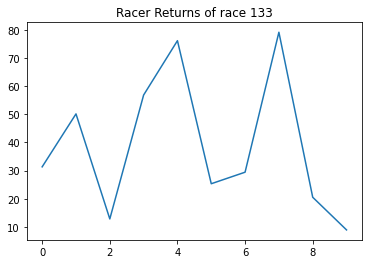

Race complete!
At race 133, finalist model is Model#(7) with episode reward 79.1
carrying following Model numbers: [4, 7]
Starting filling buffer: 134...


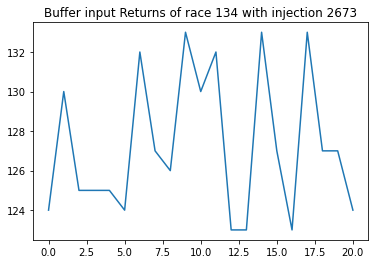

Training starts...
Buufer size: 221541, Starting race 134


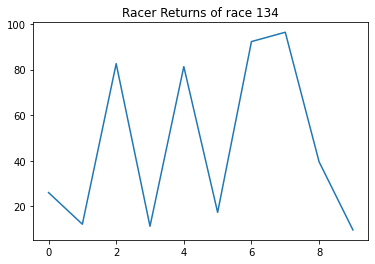

Race complete!
At race 134, finalist model is Model#(7) with episode reward 96.4
carrying following Model numbers: [6, 7]
Starting filling buffer: 135...


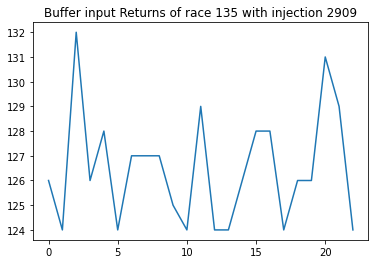

Training starts...
Buufer size: 224450, Starting race 135


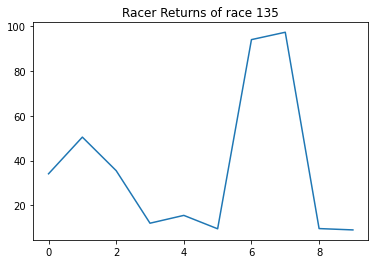

Race complete!
At race 135, finalist model is Model#(7) with episode reward 97.4
carrying following Model numbers: [6, 7]
Starting filling buffer: 136...


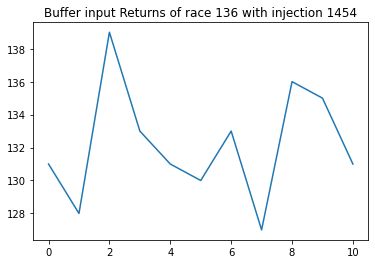

Training starts...
Buufer size: 225904, Starting race 136


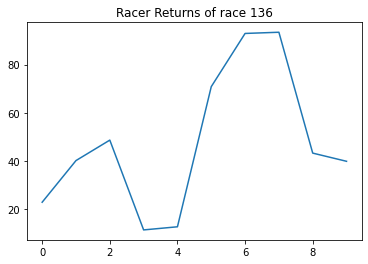

Race complete!
At race 136, finalist model is Model#(7) with episode reward 93.4
carrying following Model numbers: [6, 7]
Starting filling buffer: 137...


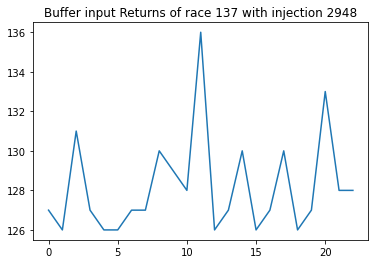

Training starts...
Buufer size: 228852, Starting race 137


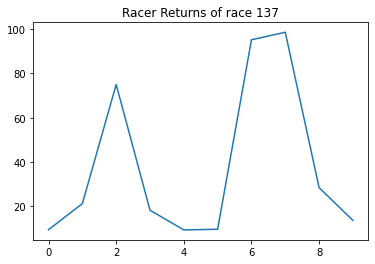

Race complete!
At race 137, finalist model is Model#(7) with episode reward 98.6
carrying following Model numbers: [6, 7]
Starting filling buffer: 138...


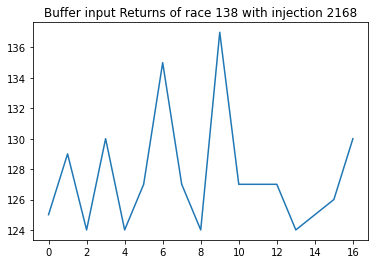

Training starts...
Buufer size: 231020, Starting race 138


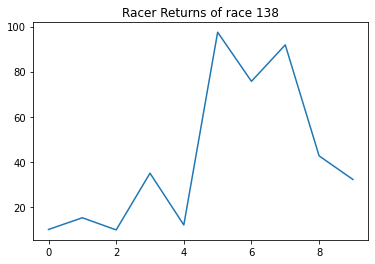

Race complete!
At race 138, finalist model is Model#(5) with episode reward 97.5
carrying following Model numbers: [5, 7]
Starting filling buffer: 139...


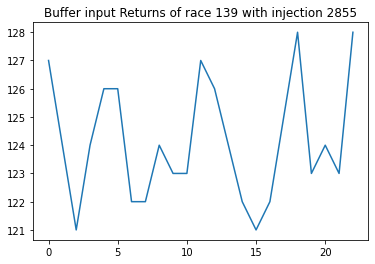

Training starts...
Buufer size: 233875, Starting race 139


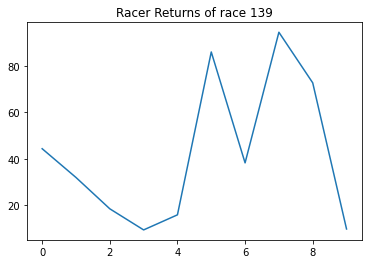

Race complete!
At race 139, finalist model is Model#(7) with episode reward 94.5
carrying following Model numbers: [5, 7]
Starting filling buffer: 140...


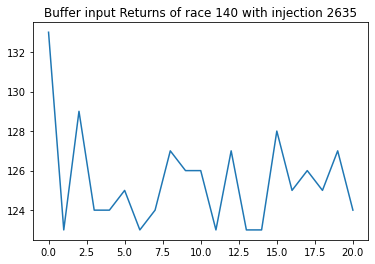

Training starts...
Buufer size: 236510, Starting race 140


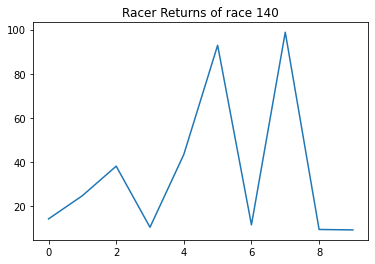

Race complete!
At race 140, finalist model is Model#(7) with episode reward 98.8
carrying following Model numbers: [5, 7]
Starting filling buffer: 141...


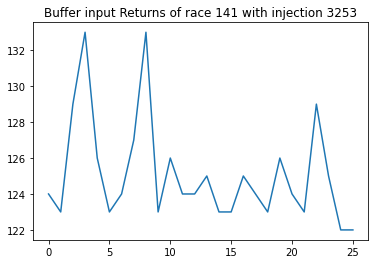

Training starts...
Buufer size: 239763, Starting race 141


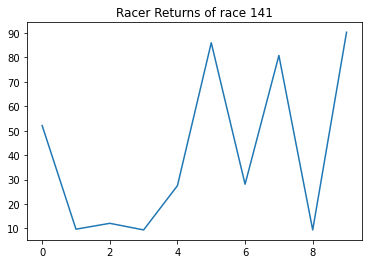

Race complete!
At race 141, finalist model is Model#(9) with episode reward 90.3
carrying following Model numbers: [5, 9]
Starting filling buffer: 142...


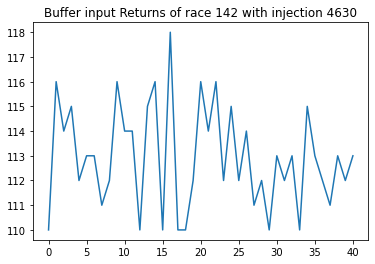

Training starts...
Buufer size: 244393, Starting race 142


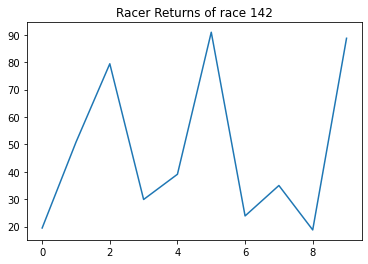

Race complete!
At race 142, finalist model is Model#(5) with episode reward 90.9
carrying following Model numbers: [5, 9]
Starting filling buffer: 143...


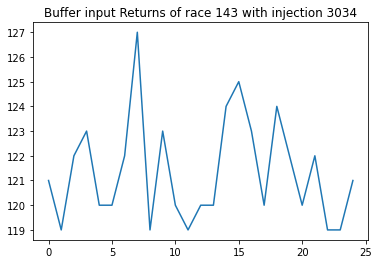

Training starts...
Buufer size: 247427, Starting race 143


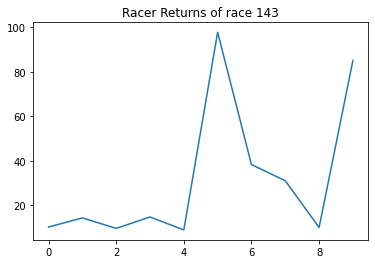

Race complete!
At race 143, finalist model is Model#(5) with episode reward 97.8
carrying following Model numbers: [5, 9]
Starting filling buffer: 144...


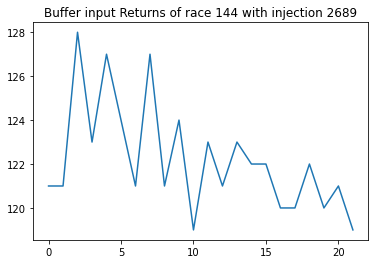

Training starts...
Buufer size: 250116, Starting race 144


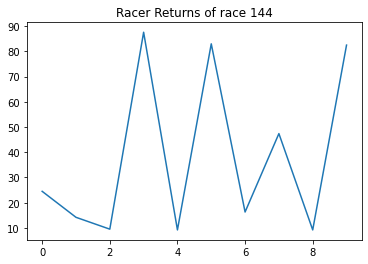

Race complete!
At race 144, finalist model is Model#(3) with episode reward 87.6
carrying following Model numbers: [3, 5]
Starting filling buffer: 145...


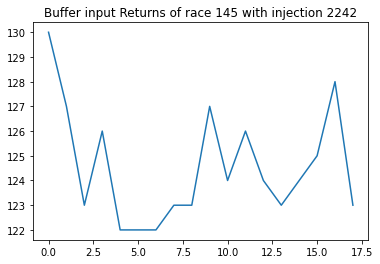

Training starts...
Buufer size: 252358, Starting race 145


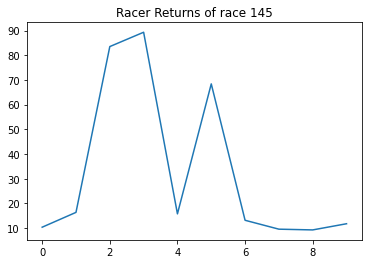

Race complete!
At race 145, finalist model is Model#(3) with episode reward 89.3
carrying following Model numbers: [2, 3]
Starting filling buffer: 146...


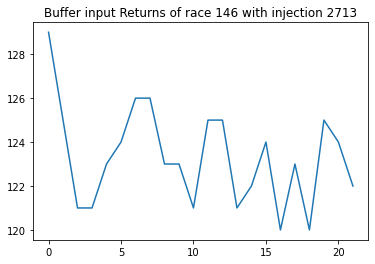

Training starts...
Buufer size: 255071, Starting race 146


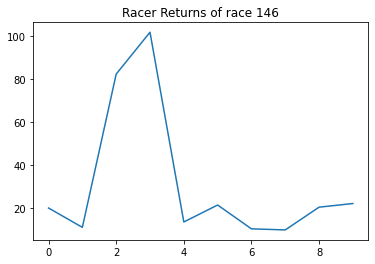

Race complete!
At race 146, finalist model is Model#(3) with episode reward 101.9
carrying following Model numbers: [3]
Starting filling buffer: 147...


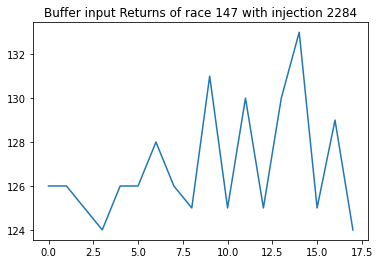

Training starts...
Buufer size: 257355, Starting race 147


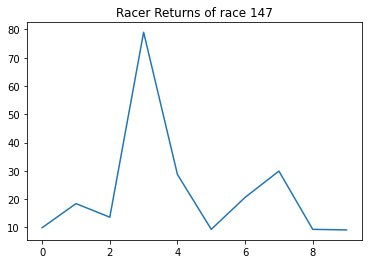

Race complete!
At race 147, finalist model is Model#(3) with episode reward 79.0
carrying following Model numbers: [3]
Starting filling buffer: 148...


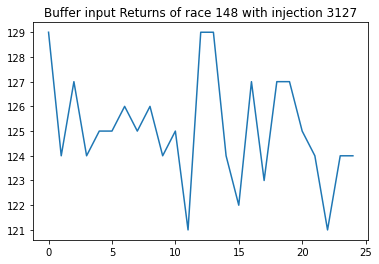

Training starts...
Buufer size: 260482, Starting race 148


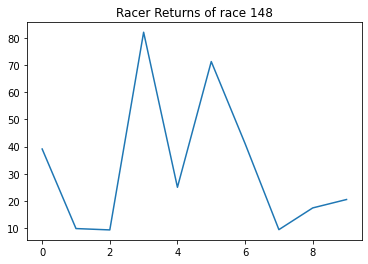

Race complete!
At race 148, finalist model is Model#(3) with episode reward 82.1
carrying following Model numbers: [3, 5]
Starting filling buffer: 149...


In [9]:
a = Agent("CartPole-v1")
print(f"Starts at {datetime.now().strftime('%y-%m-%d, %H:%M:%S')}")
a.train()
print(f"Ends at {datetime.now().strftime('%y-%m-%d, %H:%M:%S')}")